## HOW TO USE THIS NOTEBOOK


1.  Run this notebook once. It will optimize a network and store it in net.dat. It will run for 30000 iterations and generate the `net.dat` file that contains the trained network's parameters.

2. In line 210, set EVAL=True

3. Re-run the notebook. It will evaluate the trained network in `net.dat` by running 10 episodes (without changing the parameters of course), each over a batch of 500 individuals

4. See the figures



(Note: This code added some decorrelation between cues in comparison to a previous version)

In [1]:

# What GPU are we using?
!nvidia-smi

Mon Sep  4 19:41:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Includes some Uber-copyrighted code, so:

# Based on the code for the Stimulus-response task as described in Miconi et al. ICLR 2019.

# Copyright (c) 2018-2019 Uber Technologies, Inc.
#
# Licensed under the Uber Non-Commercial License (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at the root directory of this project.

import argparse
import pdb
import torch
import torch.nn as nn
import numpy as np
from numpy import random
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
import random
import sys
import pickle
import time
import os
import platform

import numpy as np
import glob



myseed = -1


# If running this code on a cluster, uncomment the following, and pass a RNG seed as the --seed parameter on the command line
# parser  = argparse.ArgumentParser()
# parser.add_argument('--seed', type=int, default=-1)
# args = parser.parse_args()
# myseed =  args.seed



# This needs to be before parameter initialization
NBMASSEDTRIALS = 0
MASSEDPAIR = [3,4]




np.set_printoptions(precision=5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'


params={}
params['rngseed']=myseed       # RNG seed, or -1 for no seed
params['rew']=1.0   # reward amount
params['wp']=.0     # penalty for taking action 1 (not used here)
params['bent']=.1       #  entropy incentive (actually sum-of-squares)
params['blossv']=.1     # value prediction loss coefficient
params['gr']=.9         # Gamma for temporal reward discounting

params['hs']=200        # Size of the RNN's hidden layer
params['bs']=32         # Batch size
params['gc']=2.0    # Gradient clipping
params['eps']=1e-6  # A parameter for Adam
params['nbiter']= 30000 # 60000
params['save_every']=200
params['pe']= 101  #"print every"


params['nbcuesrange'] = range(4,9)
# params['nbcues']= 5 # 7     # number  of inputs - number of different stimuli used for each episode

params['cs']= 15  # 10     # Cue size -  number of binary elements in each cue vector (not including the 'go' bit and additional inputs, see below)

params['triallen'] = 4 # 4  #  5 # 5 + 1 #  4 + 1  # Each trial has: stimulus presentation, 'go' cue, then 3 empty trials.
NUMRESPONSESTEP = 1
params['nbtraintrials'] = 20 # 22  # 20 #  5  #  The first  nbtraintrials are the "train" trials. This  is included in nbtrials.
params['nbtesttrials'] =  10 # 2 #  12 # 10  #  The last nbtesttrials are the "test" trials. This  is included in nbtrials.
params['nbtrials'] = params['nbtraintrials']  +  NBMASSEDTRIALS + params['nbtesttrials'] #  20   # Number of trials per episode
params['eplen'] = params['nbtrials'] * params['triallen']  # eplen = episode length
params['testlmult'] =  3.0   # multiplier for the loss during the test trials
params['l2'] = 0 # 1e-5 # L2 penalty
params['lr'] = 1e-4
params['lpw'] =  1e-4  #  3    # plastic weight loss
params['lda'] = 0 # 1e-4 # 3e-5 # 1e-4 # 1e-5 # DA output penalty
params['lhl1'] =  0 # 3e-5
params['nbepsbwresets'] = 3 # 1

PROBAOLDDATA = .25
POSALPHA = False
POSALPHAINITONLY = False
VECTALPHA =  False

# RNN with plastic connections and neuromodulation ("DA").
# Plasticity only in the recurrent connections, for now.

class RetroModulRNN(nn.Module):
    def __init__(self, params):
        super(RetroModulRNN, self).__init__()
        # NOTE: 'outputsize' excludes the value and neuromodulator outputs!
        for paramname in ['outputsize', 'inputsize', 'hs', 'bs']:
            if paramname not in params.keys():
                raise KeyError("Must provide missing key in argument 'params': "+paramname)
        NBDA = 2  # 2 DA neurons, we  take the difference  - see below
        self.params = params
        self.activ = torch.tanh
        self.i2h = torch.nn.Linear(self.params['inputsize'], params['hs']).to(device)
        self.w =  torch.nn.Parameter((  (1.0 / np.sqrt(params['hs']))  * ( 2.0 * torch.rand(params['hs'], params['hs']) - 1.0) ).to(device), requires_grad=True)
        #self.alpha =  torch.nn.Parameter((.1 * torch.ones(params['hs'], params['hs'])).to(device), requires_grad=True)
        # self.alpha =  torch.nn.Parameter((.01 * torch.ones(params['hs'], params['hs'])).to(device), requires_grad=True)
        if VECTALPHA:
            self.alpha =  .01 * (2.0 * torch.rand(params['hs'], 1) -1.0).to(device)  # A column vector, so each neuron has a single plasticity coefficient applied to all its input connections
        else:
            self.alpha =  .01 * (2.0 * torch.rand(params['hs'], params['hs']) -1.0).to(device)
        if POSALPHA or  POSALPHAINITONLY:
            self.alpha = torch.abs(self.alpha)
        self.alpha =  torch.nn.Parameter(self.alpha, requires_grad=True)
        # self.etaet = torch.nn.Parameter((.5 * torch.ones(1)).to(device), requires_grad=True)  # Everyone has the same etaet
        self.etaet = torch.nn.Parameter((.7 * torch.ones(1)).to(device), requires_grad=True)  # Everyone has the same etaet
        # self.DAmult = torch.nn.Parameter((1.0 * torch.ones(1)).to(device), requires_grad=True)  # Everyone has the same DAmult
        self.DAmult = torch.nn.Parameter((1.0 * torch.ones(1)).to(device), requires_grad=True)  # Everyone has the same DAmult
        # self.DAmult = .2
        self.h2DA = torch.nn.Linear(params['hs'], NBDA).to(device)      # DA output
        self.h2o = torch.nn.Linear(params['hs'], self.params['outputsize']).to(device)  # Actual output
        self.h2v = torch.nn.Linear(params['hs'], 1).to(device)          # V prediction

    def forward(self, inputs, hidden, et, pw):
            BATCHSIZE = inputs.shape[0]  #  self.params['bs']
            HS = self.params['hs']
            assert pw.shape[0] == hidden.shape[0] == et.shape[0] == BATCHSIZE

            # Multiplying inputs (i.e. current hidden  values) by the total recurrent weights, w + alpha  * plastic_weights
            hactiv = self.activ(self.i2h(inputs).view(BATCHSIZE, HS, 1) + torch.matmul((self.w + torch.mul(self.alpha, pw)),
                            hidden.view(BATCHSIZE, HS, 1))).view(BATCHSIZE, HS)
            activout = self.h2o(hactiv)  # Output layer. Pure linear, raw scores - will be softmaxed later
            valueout = self.h2v(hactiv)  # Value prediction

            # Now computing the Hebbian updates...

            # With batching, DAout is a matrix of size BS x 1
            DAout2 = torch.tanh(self.h2DA(hactiv))
            DAout = self.DAmult * (DAout2[:,0] - DAout2[:,1])[:,None] # DA output is the difference between two tanh neurons - allows negative, positive and easy stable 0 output (by jamming both neurons to max or min)


            # Eligibility trace gets stamped into the plastic weights  - gated by DAout
            deltapw = DAout.view(BATCHSIZE,1,1) * et
            pw = pw + deltapw

            torch.clip_(pw, min=-50.0, max=50.0)



            # Updating the eligibility trace - Hebbbian update with a simple decay
            # NOTE: the decay is for the eligibility trace, NOT the plastic weights (which never decay during a lifetime, i.e. an episode)
            deltaet =  torch.bmm(hactiv.view(BATCHSIZE, HS, 1), hidden.view(BATCHSIZE, 1, HS)) # batched outer product; at this point 'hactiv' is the output and 'hidden' is the input  (i.e. ativities from previous time step)
            # deltaet =  torch.bmm(hactiv.view(BATCHSIZE, HS, 1), hidden.view(BATCHSIZE, 1, HS)) -  et * hactiv[:, :, None] ** 2  # Oja's rule  (...? anyway, doesn't ensure stability with tanh and arbitrary damult / etaet)
            # deltaet =  torch.bmm(hactiv.view(BATCHSIZE, HS, 1), hidden.view(BATCHSIZE, 1, HS)) -   hactiv.view(BATCHSIZE, HS, 1) * et  # Instar rule (?)

            deltaet = torch.tanh(deltaet)

            et = (1 - self.etaet) * et + self.etaet *  deltaet
            # et =  deltaet

            hidden = hactiv
            return activout, valueout, DAout, hidden, et, pw




    def initialZeroET(self, mybs):
        # return torch.zeros(self.params['bs'], self.params['hs'], self.params['hs'], requires_grad=False).to(device)
        return torch.zeros(mybs, self.params['hs'], self.params['hs'], requires_grad=False).to(device)

    def initialZeroPlasticWeights(self,  mybs):
        return torch.zeros(mybs, self.params['hs'], self.params['hs'] , requires_grad=False).to(device)
    def initialZeroState(self, mybs):
        return torch.zeros(mybs, self.params['hs'], requires_grad=False ).to(device)



print("Starting...")

print("Passed params: ", params)
print(platform.uname())
suffix = "_"+"".join( [str(kk)+str(vv)+"_" if kk != 'pe' and kk != 'nbsteps' and kk != 'rngseed' and kk != 'save_every' and kk != 'test_every' else '' for kk, vv in sorted(zip(params.keys(), params.values()))] ) + "_rng" + str(params['rngseed'])  # Turning the parameters into a nice suffix for filenames
print(suffix)


# Total input size = cue size +  one 'go' bit + 4 additional inputs
ADDINPUT = 4 # 1 inputs for the previous reward, 1 inputs for numstep, 1 unused,  1 "Bias" inputs
NBSTIMBITS = 2 * params['cs'] + 1 # The additional bit is for the response cue (i.e. the "Go" cue)
params['outputsize'] =  2  # "response" and "no response"
params['inputsize'] = NBSTIMBITS  + ADDINPUT +  params['outputsize'] # The total number of input bits is the size of cues, plus the "response cue" binary input, plus the number of additional inputs, plus the number of actions


# Initialize random seeds, unless rngseed is -1 (first two redundant?)
if params['rngseed'] > -1 :
    print("Setting random seed", params['rngseed'])
    np.random.seed(params['rngseed']); random.seed(params['rngseed']); torch.manual_seed(params['rngseed'])
else:
    print("No random seed.")





# Are we running in evaluation mode?
EVAL = False


# Various possible experiments:

RESETHIDDENEVERYTRIAL = RESETETEVERYTRIAL = True #  False #  True



RESETPWEVERYTRIAL = False


ONLYTWOLASTADJ = False

LINKEDLISTSEVAL = False
LINKINGISSHAM = False

FIXEDCUES = False

HALFNOBARREDPAIRUNTILT18 = False  # Ensures that  half the batch never sees the "barred" pair before trial 18. This should only be used for one thing:  ensuring enough selects and selectadd's when looking at single-step weight changes, so that some figures look better.
BARREDPAIR = [3,4]
# BARREDPAIR = [2,3]
# TO MAKE THE PLOTS WITH ADDITIONAL BARRED PAIR:
#  1- Set the proper ADDBARREDPAIRR below (the pair just before or just after the main BARRED PAIR)
#  2- Set SHOWALLSELECTS = False below



if EVAL:
    params['nbiter'] = 1 # 5 # 10
    params['bs']  = 2000
    params['nbcues'] = 8
    if not LINKEDLISTSEVAL:
        params['nbepsbwresets'] =  1
    torch.set_grad_enabled(False)
if LINKEDLISTSEVAL:
    assert EVAL
    assert NBMASSEDTRIALS==0
    assert params['nbepsbwresets'] == 3
    params['nbiter'] = 3
    params['nbcues'] = 8 # 10
    params['bs'] = 4000
    SHOWFIRSTHALFFIRST = 1 # np.random.randint(2)
    # The following applies for the first 2 episodes, then will be modified later for the 3rd episode
    params['nbtraintrials']  = 10
    params['nbtesttrials'] = 0
    params['nbtrials'] = params['nbtraintrials'] + params['nbtesttrials']
    params['eplen'] = params['nbtrials'] * params['triallen']  # eplen = episode length

if FIXEDCUES:
    params['bs']  =  2000

BS = params['bs']   # Batch size


assert not (  (NBMASSEDTRIALS > 0 ) and (not EVAL)  )   # We should only use massed trials in eval, not training
if ONLYTWOLASTADJ:
    assert params['nbcues'] == 7
if HALFNOBARREDPAIRUNTILT18:
    assert  EVAL and (NBMASSEDTRIALS == 0) and not LINKEDLISTSEVAL and not ONLYTWOLASTADJ and not FIXEDCUES
if LINKINGISSHAM:
    assert LINKEDLISTSEVAL





print("Initializing network")
net = RetroModulRNN(params)
if EVAL:
    net.load_state_dict(torch.load('net.dat'))
    net.eval()
    # net.alpha *= -1; net.DAmult *= -1   # Should leave the system invariant







print ("Shape of all optimized parameters:", [x.size() for x in net.parameters()])
allsizes = [torch.numel(x.data.cpu()) for x in net.parameters()]
print ("Size (numel) of all optimized elements:", allsizes)
print ("Total size (numel) of all optimized elements:", sum(allsizes))

print("Initializing optimizer")
optimizer = torch.optim.Adam(net.parameters(), lr=1.0*params['lr'], eps=params['eps'], weight_decay=params['l2'])

# A lot of logging...
all_losses = []
all_grad_norms = []
all_losses_objective = []
all_mean_rewards_ep = []
all_mean_testrewards_ep = []
all_losses_v = []

oldcuedata  = []

lossbetweensaves = 0
nowtime = time.time()

nbtrials = [0]*BS
totalnbtrials = 0
nbtrialswithcc = 0

print("Starting episodes!")


for numepisode in range(params['nbiter']):


    PRINTTRACE = False
    if (numepisode) % (params['pe']) == 0 or EVAL:
        PRINTTRACE = True



    if LINKEDLISTSEVAL and numepisode == 2:
        params['nbtraintrials']  = 1 if LINKINGISSHAM  else 4 #  12 #  7
        params['nbtesttrials'] = 1
        params['nbtrials'] = params['nbtraintrials'] + params['nbtesttrials']
        params['eplen'] = params['nbtrials'] * params['triallen']  # eplen = episode length

    optimizer.zero_grad()
    loss = 0
    lossv = 0
    lossDA = 0
    lossHL1 = 0
    # The freshly generated uedata will be appended to oldcuedata later, after the episode is run
    if numepisode % params['nbepsbwresets'] == 0:
        if not EVAL:
            params['nbcues']= random.choice(params['nbcuesrange'])
        oldcuedata = []
        hidden = net.initialZeroState(BS)
        et = net.initialZeroET(BS) #  The Hebbian eligibility trace
        pw = net.initialZeroPlasticWeights(BS)
    else:
        hidden = hidden.detach()
        et = et.detach()
        pw = pw.detach()

    numstep_ep = 0
    iscorrect_thisep = np.zeros((BS, params['nbtrials']))
    istest_thisep  = np.zeros((BS, params['nbtrials']))
    isadjacent_thisep  = np.zeros((BS, params['nbtrials']))
    isolddata_thisep  = np.zeros((BS, params['nbtrials']))
    resps_thisep =  np.zeros((BS, params['nbtrials']))
    cuepairs_thisep  = []
    numactionschosen_alltrialsandsteps_thisep = np.zeros((BS, params['nbtrials'], params['triallen'])).astype(int)
    if EVAL:
        allpwsavs_thisep = []
        ds_thisep =[]; rs_thisep  = []
        allrates_thisep = np.zeros((BS, params['hs'], params['eplen']))


    # Generate the bitstring for each cue number for this episode. Make sure they're all different (important when using very small cues for debugging, e.g. cs=2, ni=2)



    # print("Generating cues...")
    if FIXEDCUES:
        # Debugging only: Never change cue data
        if  numepisode == 0:
            cuedata=[]
            for nb in range(BS):
                cuedata.append([])
                for ncue in range(params['nbcues']):
                    if nb == 0:
                        assert len(cuedata[nb]) == ncue
                        foundsame = 1
                        cpt = 0
                        while foundsame > 0 :
                            cpt += 1
                            if cpt > 10000:
                                # This should only occur with very weird parameters, e.g. cs=2, ni>4
                                raise ValueError("Could not generate a full list of different cues")
                            foundsame = 0
                            candidate = np.random.randint(2, size=params['cs']) * 2 - 1
                            for backtrace in range(ncue):
                                # if np.array_equal(cuedata[nb][backtrace], candidate):
                                if np.mean(cuedata[nb][backtrace] == candidate) > .66 :
                                # if np.abs(np.mean(cuedata[nb][backtrace] * candidate)) > .1 :
                                    foundsame = 1
                        cuedata[nb].append(candidate)
                    else:
                        cuedata[nb].append(cuedata[0][ncue])

    else:  # Not fixed cues
        if not LINKEDLISTSEVAL or numepisode == 0:
        # if numepisode == 0:   # THIS DOESN't WORK TO FIX CUES! Different nb's still have different cues
            cuedata=[]
            for nb in range(BS):
                cuedata.append([])
                for ncue in range(params['nbcues']):
                    assert len(cuedata[nb]) == ncue
                    foundsame = 1
                    cpt = 0
                    while foundsame > 0 :
                        cpt += 1
                        if cpt > 10000:
                            # This should only occur with very weird parameters, e.g. cs=2, ni>4
                            raise ValueError("Could not generate a full list of different cues")
                        foundsame = 0
                        candidate = np.random.randint(2, size=params['cs']) * 2 - 1
                        for backtrace in range(ncue):
                            # if np.array_equal(cuedata[nb][backtrace], candidate):
                            # if np.abs(np.mean(cuedata[nb][backtrace] * candidate)) > .2 :
                            # if np.sum(cuedata[nb][backtrace] != candidate) < 4: # 2:
                            if np.mean(cuedata[nb][backtrace] == candidate) > .66 :
                                foundsame = 1

                    cuedata[nb].append(candidate)
    # print("Cues generated!")





    # # The freshly generated uedata will be appended to oldcuedata later, after the episode is run
    # if numepisode % params['nbepsbwresets'] == 0:
    #     oldcuedata = []

    reward = np.zeros(BS)
    sumreward = np.zeros(BS)
    sumrewardtest = np.zeros(BS)
    rewards = []
    vs = []
    logprobs = []
    cues=[]
    for nb in range(BS):
        cues.append([])
    dist = 0
    numactionschosen = np.zeros(BS, dtype='int32')

    #reward = 0.0
    #rewards = []
    #vs = []
    #logprobs = []
    #sumreward = 0.0
    nbtrials = np.zeros(BS)
    nbtesttrials = nbtesttrials_correct = nbtesttrials_adjcues = nbtesttrials_adjcues_correct = nbtesttrials_nonadjcues = nbtesttrials_nonadjcues_correct = 0
    nbrewardabletrials = np.zeros(BS)
    thistrialhascorrectorder = np.zeros(BS)
    thistrialhasadjacentcues = np.zeros(BS)
    thistrialhascorrectanswer = np.zeros(BS)


    # 2 steps of blank input between episodes. Not sure if it helps.
    inputs = np.zeros((BS, params['inputsize']), dtype='float32')
    inputsC = torch.from_numpy(inputs).detach().to(device)
    for nn in range(2):
            y, v, DAout, hidden, et, pw  = net(inputsC, hidden, et, pw)  # y  should output raw scores, not probas



    #print("EPISODE ", numepisode)

    for numtrial  in  range(params['nbtrials']):


        if RESETHIDDENEVERYTRIAL:
            hidden = net.initialZeroState(BS)
        if RESETETEVERYTRIAL:
            # et = et * 0 # net.initialZeroET()
            et = net.initialZeroET(BS)
        if RESETPWEVERYTRIAL:
            pw = net.initialZeroPlasticWeights(BS)

        # First, we prepare the specific sequence of inputs for this trial
        # The inputs can be a pair of cue numbers, or -1 (empty stimulus), or a single number equal to params['nbcues'], which indicates the 'response' cue.
        # These will be translated into actual network inputs (using the actual bitstrings) later.
        # Remember that the actual data for each cue  (i.e. its actual bitstring) is randomly generated for each episode, above

        cuepairs_thistrial = []
        for nb in range(BS):
                thistrialhascorrectorder[nb] = 0
                cuerange = range(params['nbcues'])
                if LINKEDLISTSEVAL:
                    if SHOWFIRSTHALFFIRST:
                        if numepisode == 0:
                            cuerange = range(params['nbcues']//2)
                        elif numepisode == 1:
                            cuerange  = range(params['nbcues']//2, params['nbcues'])
                        else:
                            cuerange =  range(params['nbcues'])
                    else:
                        if numepisode == 0:
                            cuerange  = range(params['nbcues']//2, params['nbcues'])
                        elif numepisode == 1:
                            cuerange = range(params['nbcues']//2)
                        else:
                            cuerange = range(params['nbcues'])
                # # In any trial, we show exactly two cues (randomly chosen), simultaneously:
                cuepair =  list(np.random.choice(cuerange, 2, replace=False))

                # If the trial is NOT a test trial, these two cues should be adjacent
                if nbtrials[nb]  < params['nbtraintrials'] or (ONLYTWOLASTADJ and nbtrials[nb] >= params['nbtrials'] - 2):
                    if ONLYTWOLASTADJ and nbtrials[nb] >= params['nbtrials'] - 2:
                        while abs(cuepair[0] - cuepair[1]) > 1 or 0 in cuepair or 6 in cuepair:
                            cuepair =  list(np.random.choice(cuerange, 2, replace=False))
                    else:
                            while abs(cuepair[0] - cuepair[1]) > 1 :
                                cuepair =  list(np.random.choice(cuerange, 2, replace=False))
                else:
                    assert nbtrials[nb] >= params['nbtraintrials']
                    if ONLYTWOLASTADJ:
                        assert nbtrials[nb] < params['nbtrials'] - 2
                        while  not(
                            (2  in cuepair and 0 in cuepair )
                            or (2  in cuepair and 4 in cuepair )
                            or (4  in cuepair and 6 in cuepair )
                            or (3  in cuepair and 0 in cuepair )
                            or (3  in cuepair and 6 in cuepair )
                        ):
                            cuepair =  list(np.random.choice(cuerange, 2, replace=False))

                if NBMASSEDTRIALS >  0 and nbtrials[nb]  >= params['nbtraintrials']  and numtrial < params['nbtrials'] -  params['nbtesttrials']:
                    cuepair  = MASSEDPAIR

                if LINKEDLISTSEVAL and numepisode  == 2:
                    if numtrial < params['nbtraintrials']:
                        if LINKINGISSHAM:
                            cuepair = [params['nbcues']//2-3,params['nbcues']//2-2]  # Sanity check for debugging: this should lead to chance perf in the test trial of 3rd episode
                        else:
                            cuepair = [params['nbcues']//2-1,params['nbcues']//2] if np.random.randint(2) else [params['nbcues']//2,params['nbcues']//2-1]
                    # else nothing, we're in the 'test' phase (which is now only 1 trial) and we sample from all pairs above

                if nb > params['bs']//2 and HALFNOBARREDPAIRUNTILT18:
                    if numtrial == 18:
                        cuepair = BARREDPAIR if np.random.randint(2) else [BARREDPAIR[1],BARREDPAIR[0]]
                    elif numtrial < 18:
                        while True:
                            cuepair =  list(np.random.choice(cuerange, 2, replace=False))
                            if (abs(cuepair[0] - cuepair[1]) == 1) :
                                if (BARREDPAIR[0] not in cuepair) or (BARREDPAIR[1] not in cuepair):
                                    break



                thistrialhascorrectorder[nb] = 1 if cuepair[0]  <  cuepair[1] else 0
                thistrialhasadjacentcues[nb] = 1 if (abs(cuepair[0]-cuepair[1]) == 1) else  0
                isadjacent_thisep[nb,numtrial]  = thistrialhasadjacentcues[nb]
                istest_thisep[nb, numtrial] = 1 if numtrial >= params['nbtraintrials'] + NBMASSEDTRIALS else 0

                # mycues = [cuepair,cuepair]
                mycues = [cuepair,]
                cuepairs_thistrial.append(cuepair)

                # Filling up other inputs for this trial
                # # We first insert some empty time steps at random either before or after the stimulus
                # for nc in range(params['triallen'] - len(mycues)  - 3):
                #     # mycues.insert(np.random.randint(len(mycues)), -1)
                #     mycues.insert(0, -1)
                # No,  we don't do that any more.

                mycues.append(params['nbcues']) # The 'go' cue, instructing response from the network
                mycues.append(-1) # One empty  step.During the first empty step, reward (computed on the previous step) is seen by the network.
                mycues.append(-1)
                # mycues.append(-1)
                assert len(mycues) == params['triallen']
                assert  mycues[NUMRESPONSESTEP] == params['nbcues']  # The 'response' step is signalled by the 'go' cue, whose number is params['nbcues'].
                cues[nb] = mycues

        cuepairs_thisep.append(cuepairs_thistrial)

        # In test period, if there ars some old cues in the store, some trials will use old cues
        if len(oldcuedata) > 0 and numtrial >= params['nbtraintrials']      + NBMASSEDTRIALS:
            for nb in range(BS):
                if np.random.rand() < PROBAOLDDATA:
                    isolddata_thisep[nb,numtrial] = 1



        # Now we are ready to actually  run  the trial:

        for numstep in range(params['triallen']):

            inputs = np.zeros((BS, params['inputsize']), dtype='float32')

            for nb in range(BS):
                # Turning the cue number for this time step into actual (signed) bitstring inputs, using the cue  data generated at the beginning of the episode - or, ocasionally, oldcuedata
                inputs[nb, :NBSTIMBITS] = 0
                if cues[nb][numstep] != -1 and cues[nb][numstep] != params['nbcues']:
                    assert len(cues[nb][numstep]) == 2
                    if isolddata_thisep[nb, numtrial]:
                        oldpos  = np.random.randint(len(oldcuedata))
                        inputs[nb, :NBSTIMBITS-1] = np.concatenate( ( oldcuedata[oldpos][nb][cues[nb][numstep][0]][:], oldcuedata[oldpos][nb][cues[nb][numstep][1]][:]  ) )
                    else:
                        inputs[nb, :NBSTIMBITS-1] = np.concatenate( ( cuedata[nb][cues[nb][numstep][0]][:], cuedata[nb][cues[nb][numstep][1]][:]  ) )
                if cues[nb][numstep] == params['nbcues']:
                    inputs[nb, NBSTIMBITS-1] = 1  # "Go" cue

                inputs[nb, NBSTIMBITS + 0] = 1.0 # Bias neuron, probably not necessary
                inputs[nb,NBSTIMBITS +  1] = numstep_ep / params['eplen'] # Time passed in this episode. Should it be the trial? Doesn't matter much anyway.
                inputs[nb, NBSTIMBITS + 2] = 1.0 * reward[nb] # Reward from previous time step


                # Original:
                # if numstep > 0:
                #     inputs[nb, NBSTIMBITS + ADDINPUT + numactionschosen[nb]] = 1  # Previously chosen action
                # DEBUGGING !!
                # if numstep == 2:
                # if not (numtrial == 0 and numstep == 0):
                # if numstep == 0 and numtrial > 0:
                assert NUMRESPONSESTEP + 1 < params['triallen'] # If that is not the case, we must provide the action signal in the next trial (this works)
                if numstep == NUMRESPONSESTEP + 1:
                    inputs[nb, NBSTIMBITS + ADDINPUT + numactionschosen[nb]] = 1  # Previously chosen action


            # inputsC = torch.from_numpy(inputs, requires_grad=False).to(device)
            inputsC = torch.from_numpy(inputs).detach().to(device)



            pwold =  pw.clone()

            ## Running the network
            y, v, DAout, hidden, et, pw  = net(inputsC, hidden, et, pw)  # y  should output raw scores, not probas

            # This should hold true if we reset h and et (not pw) between every  episode:
            # if numstep  < 2:
            #     assert torch.sum(torch.abs(pwold-pw)) < 1e-8


            if EVAL:
                allrates_thisep[:, :, numstep_ep]  = hidden.cpu().numpy()[:,:]
                ds_thisep.append(DAout.cpu().numpy())
                rs_thisep.append(reward[:, None])
                # LIMITSAVPW = 200
                if numtrial in [0,1, 18,19]:
                    allpwsavs_thisep.append(pw.cpu().numpy().astype('float16'))
                else:
                    allpwsavs_thisep.append(None)




            # Choosing the action from the outputs
            y = F.softmax(y, dim=1)
            # Must convert y to probas to use this !
            distrib = torch.distributions.Categorical(y)
            actionschosen = distrib.sample()
            logprobs.append(distrib.log_prob(actionschosen))    # To be used later for the A2C algorithm
            # if numstep == NUMRESPONSESTEP: # 2: # 4: #3: #  2:
            #     logprobs.append(distrib.log_prob(actionschosen))    # To be used later for the A2C algorithm
            # else:
            #     logprobs.append(0)
            numactionschosen = actionschosen.data.cpu().numpy()    # Store as scalars (for the whole batch)

            if PRINTTRACE:
                print("Tr", numtrial, "Step ", numstep, ", Cue 1  (0):", inputs[0,:params['cs']], "Cue 2 (0):", inputs[0,params['cs']:2*params['cs']],
                      "Other inputs:", inputs[0, 2*params['cs']:], "\n - Outputs(0): ", y.data.cpu().numpy()[0,:], " - action chosen(0): ", numactionschosen[0],
                        "TrialLen:", params['triallen'], "numstep", numstep, "TTHCC(0): ", thistrialhascorrectorder[0], "TTHOC(0):", isolddata_thisep[0, numtrial], "Reward (based on prev step): ", reward[0], ", DAout:", float(DAout[0]), ", cues(0):", cues[0] ) #, ", cc(0):", correctcue[0])


            # Computing the rewards. This is done for each time step.
            reward = np.zeros(BS, dtype='float32')
            for nb in range(BS):
                if numactionschosen[nb] == 1:
                    # Small penalty for any non-rest action taken
                    # In practice, this would usually be 0
                    reward[nb]  -= params['wp']

                numactionschosen_alltrialsandsteps_thisep[nb, numtrial, numstep] = numactionschosen[nb]

                if numstep == NUMRESPONSESTEP: # 2: # 4: #3: #  2:
                    # This is the 'response' step of the trial (and we showed the response signal
                    assert cues[nb][numstep] == params['nbcues']
                    resps_thisep[nb, numtrial] = numactionschosen[nb] *2 - 1    # Store the response in this timestep as the response for the whole trial, for logging/analysis purposes
                    # We must deliver reward (which will be perceived by the agent at the next step), positive or negative, depending on response
                    thistrialhascorrectanswer[nb] = 1
                    if thistrialhascorrectorder[nb] and numactionschosen[nb] == 1:
                        reward[nb] += params['rew']
                    elif (not thistrialhascorrectorder[nb]) and numactionschosen[nb] == 0:
                        reward[nb] += params['rew']
                    else:
                        reward[nb] -= params['rew']
                        thistrialhascorrectanswer[nb] = 0
                    iscorrect_thisep[nb, numtrial] = thistrialhascorrectanswer[nb]

                    if ( cuepairs_thistrial[nb][0]  < cuepairs_thistrial[nb][1]  ) and numactionschosen[nb] == 1:
                        assert thistrialhascorrectanswer[nb]
                    if ( cuepairs_thistrial[nb][0]  > cuepairs_thistrial[nb][1]  ) and numactionschosen[nb] == 1:
                        assert not thistrialhascorrectanswer[nb]
                    if ( cuepairs_thistrial[nb][0]  < cuepairs_thistrial[nb][1]  ) and numactionschosen[nb] == 0:
                        assert not thistrialhascorrectanswer[nb]
                    if ( cuepairs_thistrial[nb][0]  > cuepairs_thistrial[nb][1]  ) and numactionschosen[nb] == 0:
                        assert thistrialhascorrectanswer[nb]




                if numstep == params['triallen'] - 1:
                    # This was the last step of the trial
                    nbtrials[nb] += 1
                    totalnbtrials += 1
                    if thistrialhascorrectorder[nb]:
                        nbtrialswithcc += 1



            rewards.append(reward)
            vs.append(v)
            sumreward += reward
            if numtrial >= params['nbtrials'] - params['nbtesttrials']:
                sumrewardtest += reward
            # lossDA +=  torch.sum(torch.abs(DAout))
            lossDA +=  torch.sum(torch.abs(DAout /  (1e-8 + net.DAmult)))   # This is a hack to "remove" DAmult from the L1 penalty. Assumes DAmult never goes  to < 0.
            lossHL1 += torch.mean(torch.abs(hidden))


            loss += (params['bent'] * y.pow(2).sum() / BS )   # In real A2c, this is an entropy incentive. Our original version of PyTorch did not have an entropy() function for Distribution, so we use sum-of-squares instead.

            numstep_ep  += 1


        # All steps done for this trial
        if numtrial >= params['nbtrials'] - params['nbtesttrials']:
            sumrewardtest += reward
            nbtesttrials += BS
            nbtesttrials_correct += np.sum(thistrialhascorrectanswer)
            nbtesttrials_adjcues += np.sum(thistrialhasadjacentcues)
            nbtesttrials_adjcues_correct += np.sum(thistrialhasadjacentcues * thistrialhascorrectanswer)
            nbtesttrials_nonadjcues += np.sum(1 - thistrialhasadjacentcues)
            nbtesttrials_nonadjcues_correct += np.sum((1-thistrialhasadjacentcues) * thistrialhascorrectanswer)


    # All trials done for this episode

    oldcuedata.append(cuedata)
    if EVAL:
        ds_thisep = np.hstack(ds_thisep)
        rs_thisep = np.hstack(rs_thisep)

    # Computing the various losses for A2C (outer-loop training)

    R = torch.zeros(BS, requires_grad=False).to(device)
    gammaR = params['gr']
    for numstepb in reversed(range(params['eplen'])) :
        R = gammaR * R + torch.from_numpy(rewards[numstepb]).detach().to(device)
        # ctrR = R - vs[numstepb][0]
        # ctrR = R - vs[numstepb]
        ctrR = R - vs[numstepb][:,0] # I think this is right...
        lossv += ctrR.pow(2).sum() / BS
        LOSSMULT  = params['testlmult'] if numstepb > params['eplen']  - params['triallen']  * params['nbtesttrials'] else 1.0

        # NOTE: We accumulate the logprobs from all time steps, even when the output is ignored (it is only used to sample response at time step 1, i.e. RESPONSETIME)
        # Unsurprisingly, performance is better if we anly record the logprobs for response time (and set them to 0 otherwise), but we keep this version because it was used in the paper.
        loss -= LOSSMULT * (logprobs[numstepb] * ctrR.detach()).sum() / BS  # Action poliy loss



    lossobj = float(loss)
    loss += params['blossv'] * lossv   # lossmult is not applied to value-prediction loss; is it right?...
    loss += params['lda'] * lossDA  # lossDA is loss on absolute value of DA output (see above)
    loss += params['lhl1']  * lossHL1
    loss /= params['eplen']
    losspw  = torch.mean(pw ** 2) * params['lpw']   # loss on squared final plastic weights is not divided by episode length
    loss += losspw

    if PRINTTRACE:
        print("lossobj (with coeff):", lossobj / params['eplen'], ", lossv (with coeff): ", params['blossv'] * float(lossv) / params['eplen'],
              "lossDA (with coeff): ", params['lda'] * float(lossDA) / params['eplen'],", losspw:", float(losspw))
        print ("Total reward for this episode(0):", sumreward[0], "Prop. of trials w/ rewarded cue:", (nbtrialswithcc / totalnbtrials),  " Total Nb of trials:", totalnbtrials)
        print("Nb Test Trials:", nbtesttrials, ", Nb Test Trials AdjCues:", nbtesttrials_adjcues, ", Nb Test Trials NonAdjCues:", nbtesttrials_nonadjcues)
        if nbtesttrials > 0:
            # Should always be the  case except for LinkedListsEval
            print("Test Perf (both methods):", np.array([nbtesttrials_correct / nbtesttrials, np.sum(iscorrect_thisep * istest_thisep) / np.sum(istest_thisep)]),
                        "Test Perf AdjCues:", np.array([(nbtesttrials_adjcues_correct / nbtesttrials_adjcues)]) if nbtesttrials_adjcues > 0 else 'N/A',
                        "Test Perf NonAdjCues:", np.array([nbtesttrials_nonadjcues_correct / nbtesttrials_nonadjcues]) if nbtesttrials_nonadjcues > 0 else 'N/A',
                        "Test perf old cues:",  np.array([np.sum(iscorrect_thisep * istest_thisep * isolddata_thisep) /  np.sum(istest_thisep * isolddata_thisep)])  if np.sum(istest_thisep * isolddata_thisep) > 0 else "N/A" ,
              )


    if not EVAL:
        loss.backward()
        gn = torch.nn.utils.clip_grad_norm_(net.parameters(), params['gc'])
        all_grad_norms.append(gn)
        if numepisode > 100:  # Burn-in period
            optimizer.step()
            if POSALPHA:
                torch.clip_(net.alpha.data, min=0)


    lossnum = float(loss)
    lossbetweensaves += lossnum
    all_losses_objective.append(lossnum)
    all_mean_rewards_ep.append(sumreward.mean())
    all_mean_testrewards_ep.append(sumrewardtest.mean())


    if PRINTTRACE:

        print("Episode", numepisode, "====")
        print("Mean loss: ", lossbetweensaves / params['pe'])
        lossbetweensaves = 0
        print("Mean reward per episode (over whole batch and last", params['pe'], "episodes: ", np.sum(all_mean_rewards_ep[-params['pe']:])/ params['pe'])
        print("Mean test-time reward per episode (over whole batch and last", params['pe'], "episodes: ", np.sum(all_mean_testrewards_ep[-params['pe']:])/ params['pe'])
        previoustime = nowtime
        nowtime = time.time()
        print("Time spent on last", params['pe'], "iters: ", nowtime - previoustime)

        # print(" etaet: ", net.etaet.data.cpu().numpy(), " DAmult: ", net.DAmult.data.cpu().numpy(), " mean-abs pw: ", np.mean(np.abs(pw.data.cpu().numpy())))
        print(" etaet: ", net.etaet.data.cpu().numpy(), " DAmult: ", float(net.DAmult), " mean-abs pw: ", np.mean(np.abs(pw.data.cpu().numpy())))
        print("min/max/med-abs w, alpha, pw")
        print(float(torch.min(net.w)), float(torch.max(net.w)), float(torch.median(torch.abs(net.w))))
        print(float(torch.min(net.alpha)), float(torch.max(net.alpha)), float(torch.median(torch.abs(net.alpha))))
        print(float(torch.min(pw)), float(torch.max(pw)), float(torch.median(torch.abs(pw))))
        # pwc = pw.cpu().numpy()
        # print(np.min(pwc), np.max(pwc), np.median(np.abs(pwc)))

    # if (numepisode) % params['save_every'] == 0:
    if EVAL:
        np.savez('outcomes_'+str(numepisode)+'.npz',  c=iscorrect_thisep.astype(int), a=isadjacent_thisep.astype(int),
                 cp=np.moveaxis(np.array(cuepairs_thisep),1,0), r=resps_thisep.astype(int), ac = numactionschosen_alltrialsandsteps_thisep.astype(int))
        np.save('allrates_thisep_'+str(numepisode)+'.npy', allrates_thisep)

    if (numepisode) % params['save_every'] == 0 and numepisode  > 0:
        losslast100 = np.mean(all_losses_objective[-100:])
        print("Average loss over the last 100 episodes:", losslast100)
        print("Saving local files...")

        if (not EVAL) and numepisode > 0:
            # print("Saving model parameters...")
            # torch.save(net.state_dict(), 'net_'+suffix+'.dat')
            torch.save(net.state_dict(), 'netAE'+str(params['rngseed'])+'.dat')
            torch.save(net.state_dict(), 'net.dat')

        # with open('rewards_'+suffix+'.txt', 'w') as thefile:
        #     for item in all_mean_rewards_ep[::10]:
        #             thefile.write("%s\n" % item)
        # with open('testrew_'+suffix+'.txt', 'w') as thefile:
        #     for item in all_mean_testrewards_ep[::10]:
        #             thefile.write("%s\n" % item)
        with open('tAE'+str(params['rngseed'])+'.txt', 'w') as thefile:
            for item in all_mean_testrewards_ep[::10]:
                    thefile.write("%s\n" % item)




Starting...
Passed params:  {'rngseed': -1, 'rew': 1.0, 'wp': 0.0, 'bent': 0.1, 'blossv': 0.1, 'gr': 0.9, 'hs': 200, 'bs': 32, 'gc': 2.0, 'eps': 1e-06, 'nbiter': 30000, 'save_every': 200, 'pe': 101, 'nbcuesrange': range(4, 9), 'cs': 15, 'triallen': 4, 'nbtraintrials': 20, 'nbtesttrials': 10, 'nbtrials': 30, 'eplen': 120, 'testlmult': 3.0, 'l2': 0, 'lr': 0.0001, 'lpw': 0.0001, 'lda': 0, 'lhl1': 0, 'nbepsbwresets': 3}
uname_result(system='Linux', node='7e74b6d88399', release='5.15.109+', version='#1 SMP Fri Jun 9 10:57:30 UTC 2023', machine='x86_64')
_bent0.1_blossv0.1_bs32_cs15_eplen120_eps1e-06_gc2.0_gr0.9_hs200_l20_lda0_lhl10_lpw0.0001_lr0.0001_nbcuesrangerange(4, 9)_nbepsbwresets3_nbiter30000_nbtesttrials10_nbtraintrials20_nbtrials30_rew1.0_testlmult3.0_triallen4_wp0.0__rng-1
No random seed.
Initializing network
Shape of all optimized parameters: [torch.Size([200, 200]), torch.Size([200, 200]), torch.Size([1]), torch.Size([1]), torch.Size([200, 37]), torch.Size([200]), torch.Size([2,

In [3]:
if EVAL == False:
    raise ValueError("No need to go further if not in EVAL mode.")

In [4]:
pp = print

In [5]:
    # R = torch.zeros(BS, requires_grad=False).to(device)
    # gammaR = params['gr']
    # for numstepb in reversed(range(params['eplen'])) :
    #     R = gammaR * R + torch.from_numpy(rewards[numstepb]).detach().to(device)
    #     ctrR = R - vs[numstepb][0]
    #     lossv += ctrR.pow(2).sum() / BS
    #     LOSSMULT  = params['testlmult'] if numstepb > params['eplen']  - params['triallen']  * params['nbtesttrials'] else 1.0
    #     loss -= LOSSMULT * (logprobs[numstepb] * ctrR.detach()).sum() / BS  # Action poliy loss


pp(vs[numstepb][0].shape)
pp(vs[numstepb][:,0].shape)
pp(vs[numstepb].shape)
pp(R.shape)

pp( (R-vs[numstepb]).shape )
pp( (R-vs[numstepb][:,0]).shape )
pp( (R-vs[numstepb][0]).shape )


torch.Size([1])
torch.Size([2000])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000, 2000])
torch.Size([2000])
torch.Size([2000])


In [6]:
# net.alpha *= -1.0
# net.DAmult *= -1.0
# torch.save(net.state_dict(), 'net30K13_flip.dat')


In [7]:
print([float(x)  for x in [torch.min(net.alpha), torch.max(net.alpha)]])
print([float(x)  for x in [torch.mean(net.alpha), torch.median(net.alpha)]])
print(float(torch.mean((net.alpha>0).float())))


[-0.0783945694565773, 0.19026635587215424]
[0.0037156420294195414, 0.0023802979849278927]
0.5877249836921692


DAmultiplier: 1.0


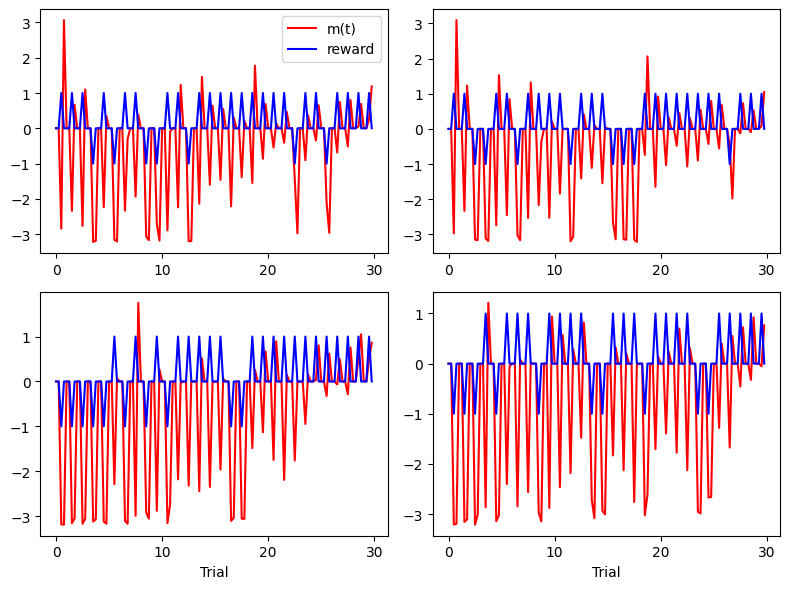

In [8]:

import matplotlib.pyplot as plt

torch.set_grad_enabled(False)


# Note: this is reward computed in previous stime step, shown at the time it is percceived byb the agent....
# That is: rreward is computed at response time (2nd time step of each trial), then perceived by the agent at the next step (3rd time step)
# The DA output at time t perceives rreward shown at time t too.


# ================
# ================
DAmultiplier = 1.0

if False:
    # We may adjust direction of DA trace depending on whether alpha is mostly-negative or mostly-positive? Better not, too confusing. Just realize that sometimes mutually-compensating sign changes will occur, which don't affect the overall algorithm

    DAmultiplier = 1.0 if float(torch.median(net.alpha)) > 0 else  -1.0

    net.alpha *= DAmultiplier

    net.DAmult *= DAmultiplier
    allpwsavs_thisep = [x * DAmultiplier if x is not None else None for x in allpwsavs_thisep ]
    ds_thisep = ds_thisep * DAmultiplier

# ================
# ================


print("DAmultiplier:", DAmultiplier)

LL = params['eplen']
TL = params['triallen']

xt  = np.arange(0, ds_thisep.shape[1]+1, TL*10)

plt.figure(figsize=(8,6))

ds= ds_thisep.copy()
rs = rs_thisep.copy()


for numplot  in range(4):
    ds_blank01 = ds[numplot,:].copy()
    if RESETHIDDENEVERYTRIAL:
        # If we reset h and et every trial, the  first two steps of DA for each trial are  irrelevant because there can't be any weight modification
        # So we zero them out (might as well not show them but the graph would look bizarre)
        # ds_blank01_b[0::params['triallen']] = [np.NAN for x in ds_blank01[0::params['triallen']]]
        # ds_blank01_b[1::params['triallen']] = [np.NAN for x in ds_blank01[1::params['triallen']]]
        ds_blank01[0::params['triallen']] = [0 for x in ds_blank01[0::params['triallen']]]
        ds_blank01[1::params['triallen']] = [0 for x in ds_blank01[1::params['triallen']]]
    plt.subplot(2,2,numplot+1)
    plt.plot(ds_blank01, 'r', label='m(t)')
    plt.plot(rs[numplot, :], 'b', label='reward')
    # plt.xticks((xt-1)*4, xt)
    plt.xticks(xt, xt//TL)
    if numplot >1:
        plt.xlabel('Trial')
    if numplot ==0:
        plt.legend()
    if NBMASSEDTRIALS > 0:
        plt.axvspan(params['nbtraintrials']* TL, params['nbtraintrials']*TL  +  NBMASSEDTRIALS * TL, color='orange', alpha=0.2, lw=0)

plt.tight_layout()
plt.savefig('traces.png', dpi=300)


# raise ValueError

In [9]:
# raise ValueError

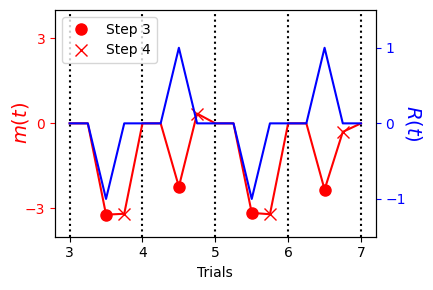

In [10]:
# Zoom
if not LINKEDLISTSEVAL:
    numplot = 0
    NUMTRIAL_Z = 3
    plt.figure(figsize=(4.5,3))
    ds_blank01 = ds[numplot,:].copy()
    ds_blank01[0::params['triallen']] = [0 for x in ds_blank01[0::params['triallen']]]
    ds_blank01[1::params['triallen']] = [0 for x in ds_blank01[1::params['triallen']]]
    rz = rs[numplot, NUMTRIAL_Z * params['triallen']:NUMTRIAL_Z * params['triallen'] + params['triallen']*4+1]
    dz = ds_blank01[NUMTRIAL_Z * params['triallen']:NUMTRIAL_Z * params['triallen'] + params['triallen']*4+1]
    maxlen = len(rz)
    plt.xticks(np.arange(0, maxlen, params['triallen']), NUMTRIAL_Z  + np.arange(0, maxlen // params['triallen']+1))
    for ybar in np.arange(0, maxlen, params['triallen']):
        plt.axvline(x=ybar, color='k', ls=':')
    plt.xlabel('Trials')
    plt.plot(dz, 'r')
    # plt.plot(range(2,maxlen,params['triallen']), rz[2::params['triallen']], 'o', markersize=10)
    plt.plot(range(2,maxlen,params['triallen']), dz[2::params['triallen']], 'ro', markersize=8, label='Step 3')
    # plt.plot(range(3,maxlen,params['triallen']), rz[3::params['triallen']], 'x', markersize=10)
    plt.plot(range(3,maxlen,params['triallen']), dz[3::params['triallen']], 'rx', markersize=8, label='Step 4')
    plt.ylim((-4,4))
    plt.yticks((-3, 0, 3))
    plt.ylabel('$m(t)$', fontsize=14, color='r')
    plt.gca().yaxis.set_label_coords(-.075,.5)
    plt.tick_params(axis='y', colors='r')
    plt.legend(loc='upper left')

    ax2 = plt.twinx()
    ax2.plot(rz, 'b')
    ax2.set_ylim((-1.5, 1.5))
    ax2.set_yticks((-1, 0, 1))
    ax2.set_ylabel('$R(t)$', color='b', fontsize=14, rotation=-90)
    # ax2.yaxis.label.set_color('b')
    ax2.tick_params(axis='y', colors='b')
    ax2.yaxis.set_label_coords(1.15,.5)

    plt.tight_layout()
    plt.savefig('zoom.png', dpi=300)



(2000, 120) (2000, 120)
(2000,) (2000,)
[-1.  1.]
(918,) (1082,)
0.0
0.0


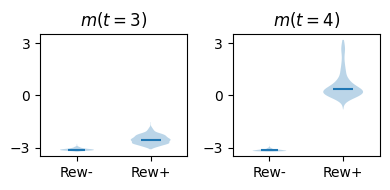

In [11]:
import scipy
from scipy import stats

# NUMTRIAL_VP = 1
NUMTRIAL_VP = 4
# NUMTRIAL_VP = 18
print(ds.shape, rs.shape)
# dt2 = ds[:,2::params['triallen']]; rt2 = rs[:,2::params['triallen']]
# dt3 = ds[:,3::params['triallen']]; rt3 = rs[:,3::params['triallen']]
dt2 = ds[:,NUMTRIAL_VP * params['triallen'] + 2]
rt2 = rs[:,NUMTRIAL_VP * params['triallen'] + 2]
dt3 = ds[:,NUMTRIAL_VP * params['triallen'] + 3]
# rt3 = rs[:,18*params['triallen'] + 3]. # We only use rt2, since reward is only given at t=2 !
print(dt2.shape, rt2.shape)
print(np.unique(rt2))
dt2_rpos = dt2[rt2 > 0]
dt2_rneg = dt2[rt2 < 0]
dt3_rpos = dt3[rt2 > 0] # note: using rt2
dt3_rneg = dt3[rt2 < 0] # note: using rt2
print(dt2_rneg.shape, dt2_rpos.shape) # the dt3_x have th same shapes

plt.figure(figsize=(4,2))

plt.subplot(1,2,1)
# x_dt2_rpos = .1 * (np.random.randn(dt2_rpos.size) - .5)
plt.violinplot((dt2_rneg, dt2_rpos), showextrema=False, showmedians=True, widths = [dt2_rneg.size / dt2.size, dt2_rpos.size / dt2.size])
plt.xlim((.5, 2.5))
plt.xticks((1, 2), ('Rew-', 'Rew+'))
res = scipy.stats.mannwhitneyu(dt2_rneg, dt2_rpos)
print(res.pvalue)
plt.ylim((-3.5, 3.5))
plt.yticks((-3,0,3))
plt.title('$m(t=3)$')

plt.subplot(1,2,2)
plt.violinplot((dt3_rneg, dt3_rpos),  showextrema=False, showmedians=True, widths = [dt3_rneg.size / dt3.size, dt3_rpos.size / dt3.size])
plt.ylim((-3.5, 3.5))
plt.yticks((-3,0,3))
plt.xlim((.5, 2.5))
plt.xticks((1, 2), ('Rew-', 'Rew+'))
res = scipy.stats.mannwhitneyu(dt3_rneg, dt3_rpos)
# res = scipy.stats.mannwhitneyu(dt3_rneg, np.random.permutation(dt3_rneg)) # For debugging
print(res.pvalue)
plt.title('$m(t=4)$')

plt.tight_layout()
plt.savefig('violin.png', dpi=300)


In [12]:
# print(ds[0,2::4])
# print(ds[0,3::4])
# print("Correlation between DA at time steps 2 and 3 across trials (all batch):", np.corrcoef(ds[:,2::4].flatten(), ds[:,3::4].flatten())[0,1])
# print("Correlation between DA at time step 2 and trial reward across trials (all batch):", np.corrcoef(ds[:,2::4].flatten(), rs[:,2::4].flatten())[0,1])
# print("Correlation between DA at time step 3 and trial reward across trials  (all batch):", np.corrcoef(ds[:,3::4].flatten(), rs[:,2::4].flatten())[0,1])
# print("Covariance between DA at time step 2 and trial reward across trials (all batch):", np.cov(ds[:,2::4].flatten(), rs[:,2::4].flatten())[0,1])
# print("Covariance between DA at time step 3 and trial reward across trials  (all batch):", np.cov(ds[:,3::4].flatten(), rs[:,2::4].flatten())[0,1])



In [13]:
# Performances IN THE TEST PHASE are collected for all pairs

orderofcuepairs=[]
for nc in range(1,params['nbcues']):
    for nc2 in range(params['nbcues']):
        if nc+nc2 >= params['nbcues']:
            break
        orderofcuepairs.append([nc2, nc2+nc])
print(orderofcuepairs)


e = 2 if LINKEDLISTSEVAL else 0
o = np.load('outcomes_'+str(e)+'.npz', allow_pickle=True); c  = o['c']; a = o['a']; na = 1-a; cp = o['cp']; r = o['r']


if ONLYTWOLASTADJ:
    testperf_adj = np.sum(c[:,-2:] * a[:,-2:]) /  np.sum(a[:, -2:] )
    testperf_nonadj = np.sum(c[:,-2:] * na[:,-2:]) /  np.sum(na[:, -2:] )
    print(testperf_adj, testperf_nonadj)

allperfs = []
NBSPLITS =  10
SPLITSIZE  = BS // NBSPLITS
for nsp in range(NBSPLITS):
    # c = corrects[e]
    # a = adjs[e]
    # cp = cuepairs[e]
    # r  = resps[e]
    perfs =  np.zeros(len(orderofcuepairs))
    nbs =  np.zeros(len(orderofcuepairs))
    for pos, p in enumerate(orderofcuepairs):
        nbthispair = nbcorrectthispair  = 0
        for nb in range(nsp*SPLITSIZE, nsp*SPLITSIZE + SPLITSIZE):
            for nt in range(cp.shape[1]):
                if nt < params['nbtrials'] - params['nbtesttrials']:
                # if nt > 2: # Should be terrible
                    continue
                if ( cp[nb, nt, 0]  == p[0]  and cp[nb, nt, 1]  == p[1]) or ( cp[nb, nt, 0]  == p[1]  and cp[nb, nt, 1]  == p[0]):
                    nbthispair += 1
                    if (cp[nb, nt, 0]  == p[0]  and r[nb,nt] == 1) or (cp[nb, nt, 0]  == p[1]  and r[nb,nt] == -1):  # response was correct
                        assert c[nb,nt] == 1  # In this house we believe in consistency
                        nbcorrectthispair += 1
        assert nbthispair > 0
        perfs[pos]  = nbcorrectthispair / nbthispair if nbthispair > 0 else -10
        nbs[pos] = nbthispair
    allperfs.append(perfs)

# else:
#     for e in range(NBEPISODES):
#         c = corrects[e]
#         a = adjs[e]
#         cp = cuepairs[e]
#         r  = resps[e]
#         perfs =  np.zeros(len(orderofcuepairs))
#         nbs =  np.zeros(len(orderofcuepairs))
#         for pos, p in enumerate(orderofcuepairs):
#             nbthispair = nbcorrectthispair  = 0
#             for nb in range(cp.shape[0]):
#                 for nt in range(cp.shape[1]):
#                     if nt < params['nbtrials'] - params['nbtesttrials']:
#                     # if nt > 2: # Should be terrible
#                         continue
#                     if ( cp[nb, nt, 0]  == p[0]  and cp[nb, nt, 1]  == p[1]) or ( cp[nb, nt, 0]  == p[1]  and cp[nb, nt, 1]  == p[0]):
#                         nbthispair += 1
#                         if (cp[nb, nt, 0]  == p[0]  and r[nb,nt] == 1) or (cp[nb, nt, 0]  == p[1]  and r[nb,nt] == -1):  # response was correct
#                             assert c[nb,nt] == 1  # In this house we believe in consistency
#                             nbcorrectthispair += 1
#             perfs[pos]  = nbcorrectthispair / nbthispair if nbthispair > 0 else -0.1
#             nbs[pos] = nbthispair
#         allperfs.append(perfs)


# allperfs contains the performance for each pair, for each split

allperfs = np.array(allperfs)
print(np.median(allperfs, axis=0))
print(nbs)
print(allperfs.shape)


[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [0, 3], [1, 4], [2, 5], [3, 6], [4, 7], [0, 4], [1, 5], [2, 6], [3, 7], [0, 5], [1, 6], [2, 7], [0, 6], [1, 7], [0, 7]]
[0.92445 0.87032 0.82378 0.80903 0.83097 0.88333 0.94118 0.91865 0.87418
 0.82433 0.83279 0.88707 0.9182  0.9504  0.90075 0.8928  0.91205 0.94559
 0.9558  0.93884 0.94405 0.9722  1.      0.98019 0.98573 1.      1.
 1.     ]
[82. 55. 65. 79. 64. 60. 79. 72. 89. 66. 78. 70. 64. 76. 70. 59. 73. 62.
 70. 68. 72. 86. 66. 66. 83. 76. 80. 70.]
(10, 28)


NOTE: This figure may look quite different every time you re-run the notebook, even if you use the same network parameters.
0 7
7 13
13 18
18 22
22 25
25 27
27 28


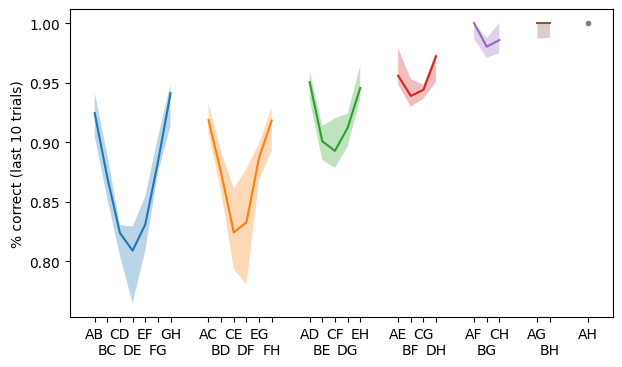

In [14]:
print("NOTE: This figure may look quite different every time you re-run the notebook, even if you use the same network parameters.")

plt.figure(figsize=(7,4))

alphabet = [chr(i) for i in range(ord('A'),ord('Z')+1)]     # How did we live without StackOverflow?

# assert params['nbcues'] == 8  # Not sure if necessary
strt = 0
offset = 0 # offset is only  here to put gaps in the x axis of the graph, it's not used to compute the actual values
rnge = params['nbcues']-1
xtks0 = []
xtks1 = []
for nump in range(params['nbcues']-1):
    print(strt, strt+rnge)
    # xtks = xtks + [alphabet[x[0]]+alphabet[x[1]] for x in orderofcuepairs[strt:strt+rnge]]
    # xtks = xtks + [alphabet[x[0]]+alphabet[x[1]]
    xtks0 = xtks0 + list(range(strt+offset, strt+rnge+offset))
    for numx, x in enumerate(orderofcuepairs[strt:strt+rnge]):
        xtks1= xtks1  + [('\n' if numx  % 2 ==  1 else '')  +  alphabet[x[0]] +alphabet[x[1]]]

    plt.plot(range(strt+offset,strt+rnge+offset), np.median(allperfs[:,strt:strt+rnge], axis=0))
    plt.fill_between(range(strt+offset,strt+rnge+offset), np.quantile(allperfs[:,strt:strt+rnge], .25, axis=0), np.quantile(allperfs[:,strt:strt+rnge], .75, axis=0), alpha=.3)

    # plt.plot(range(strt+offset,strt+rnge+offset), np.mean(allperfs[:,strt:strt+rnge], axis=0))
    # plt.fill_between(range(strt+offset,strt+rnge+offset), np.mean(allperfs[:,strt:strt+rnge], axis=0) - np.std(allperfs[:,strt:strt+rnge], axis=0),
    #                  np.mean(allperfs[:,strt:strt+rnge], axis=0) + np.std(allperfs[:,strt:strt+rnge], axis=0), alpha=.3)

    if  rnge  == 1:

        plt.plot([strt+offset], [np.median(allperfs[:,strt])], '.')
        plt.errorbar([strt+offset], [np.median(allperfs[:,strt]),], [[np.median(allperfs[:,strt]) - np.quantile(allperfs[:,strt], .25)],  [np.quantile(allperfs[:,strt], .75) - np.median(allperfs[:,strt])]])  # The most troublesome line in the whole codebase. We love matplotlib.

        # plt.plot([strt+offset], [np.mean(allperfs[:,strt])], '.')
        # plt.errorbar([strt+offset], [np.mean(allperfs[:,strt]),], [np.std(allperfs[:,strt]),] )  # The most troublesome line in the whole codebase. We love matplotlib.

    strt += rnge
    rnge -=  1
    offset  += 2
# plt.xticks(range(strt+offset-2), xtks[:strt+offset-2])
plt.xticks(xtks0, xtks1)
plt.ylabel('% correct (last '+str(params['nbtesttrials'])+' trials)')
if LINKEDLISTSEVAL:
    plt.axhline(y=0.5, color='k', linestyle='--')
    plt.ylabel('% correct (last test trial)')
else:
    plt.ylabel('% correct (last '+str(params['nbtesttrials'])+' trials)')

if not  FIXEDCUES:
    if LINKEDLISTSEVAL:
        plt.savefig('SDE_LINKEDLISTS'+('_SHAM' if LINKINGISSHAM else '')+'.png', dpi=300)
    else:
        plt.savefig('SDE.png', dpi=300)


In [15]:
if LINKEDLISTSEVAL:
    raise(ValueError("No point in going further for linked-lists experiments"))

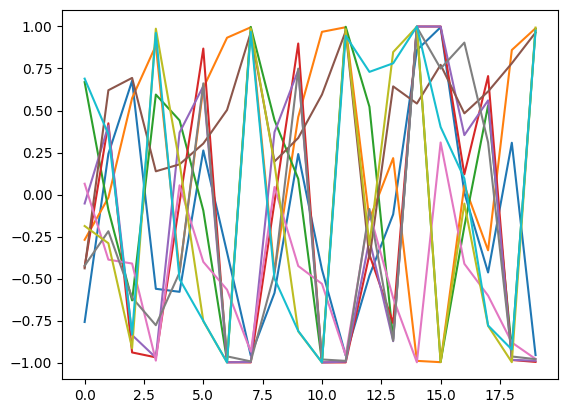

In [16]:


a = np.load('allrates_thisep_0.npy')
plt.plot(a[0, :10, -20:].T)  # Notice the T. 10 first neurons, 20 last timesteps (for whole eplisode, so several trials)

In [17]:
# Try to predict whether the first cue was cue number X, based on firing  rates at time T for the last trial
# Corr on test set: .5 for cues 0 and 6, .2 for 1 and 5, all the rest terrible....... This is only if T = 2 or 3, none other.
# Trial 19: stmi 0 is .25, 6 is .23, 1 is .1
# Also same values for logistic regression.

# Also tried to predict simply  whether the cued were correctly  orderd (i.e. the correct response)
# First, panic attack: great correlation from trial 0 !!
# But then I realized it was for position in trial 3 - after reward is received!
# By contrast, at pos 2, correlation (i.e. ability to detect whether the two cues were correctly
# ordered from neural rates) is ~0 at trrial 0, but >.8 at trial 29. Good!
# at trial 19, only .5 corr... (though note that this is on an adjacent pairs)  - at trial 20, .74... logistic: .6+-.8/.

# Pos 2, trial 29: perfect-ish prediction of the difference between the ranks of stims1 and stim2 - even though prediction of "whether ue N  is the 1st/2nd" is very bad (for non-end cues, and not very good for end-cues)...
# This requires recurrent step. At trial time 1, prediction is at chance, correlation 0.03... Strange? No, there was no randomness, theempty cue is always before the stimulus.
# trial 19 (ie only on adjacent pairs): predicts only at ~.5 corr. trial  20: .8, trial 22: .86

# What about simplypredicting stim1 and stim2's rank themselves?...Decent, butnot perfect prediction - corr is .75 io .94.
# Trial 19: chance!! (-.002), Trial 20: .64,
#Predictiing  the value of the firstcue jumps from ~0  at trial 19, to .6+ at trial 20 !... .5 trial 29.

# NOTE: until trial 20, ordered and dists are essentially the same quantity with different scaling (because only adjacent pairs)

# At trial pos 1 (stim presentation), nothing can be decoded. Yet 'hidden' definitely registers the inputs - if I pass in TTHCO as an input, decoding or ordered  becomes 1.0 (also, deoding of 'first' becomes very good, espeically when non-adjacent?....)
#  Unsurprising. There is no way  it can register inputs as anything other than their actual bitstring content, since input weights are non-plastic.
# However, ability  to now decode first-0 (better  than first_3) and first (even better after 20!) is surprising. Is it plasticity-related?
# Same (giving TTHCO as input) but resetting pw and et at beginnign of all trials. Similar... Note that this ability is flat before 20 and after.
# So at trial pos 1, *IF* the decoder has access to TTHCO  and whatever it sees at time 1, it can decode 'first' to good value (.2 bbefore 20, equall to first_0, .6 after 20, better than first_0, first_3 always chance)...
# ..  but not without TTHCO - then it can decode nothing at all.
# Confirmed that it's really the information itself thst matters, not indirecct through recurrence or plasticity (if numtrial > 19 and numtrial % 2  != 0 and numstep == 1:, rreset everything, get the expected serrated curves)
# Note that you also get the  dists to .8, afyer trial 20...
# But lol, you get  the same values with zeroing out the cue input
# So you can decode 'first' to .6 (after 20) justfrom knowing TTHCO...


import  sklearn.linear_model
import sklearn.neural_network

# biga = [];  bigcp  = []; bigcorr= []; bigresps = []; bigac = []
# for numep in range(NBEPISODES):
#     biga.append(np.load('allrates_thisep_'+str(numep)+'.npy'))
#     o = np.load('outcomes_'+str(numep)+'.npz', allow_pickle=True);
#     bigac.append(o['ac'])
#     bigcp.append(o['cp'])
#     bigcorr.append(o['c'])
#     bigresps.append(o['r'])


numep = 2 if LINKEDLISTSEVAL else 0
o = np.load('outcomes_'+str(e)+'.npz', allow_pickle=True); corr  = o['c']; ac = o['ac']; cp = o['cp']; resps = o['r']

allrates  = np.load('allrates_thisep_'+str(numep)+'.npy')

# cp = np.vstack(bigcp)
# asav = a.copy()
# corr = np.vstack(bigcorr)
# resps =  np.vstack(bigresps)
# ac = np.vstack(bigac)
print(cp.shape, a.shape, corr.shape,  resps.shape, ac.shape)
#(5000, 30, 2) (5000, 200, 150) (5000, 30) (5000, 30) (5000, 30, 5)
print(np.unique(resps))  # -1, 1
print(np.unique(ac))  # 0, 1

a = allrates.copy()

assert cp.shape[0] == BS and cp.shape[1] == params['nbtrials']
assert a.shape[0] == BS and a.shape[1] == params['hs'] and  a.shape[2] == params['eplen']
assert corr.shape[0] ==  BS and corr.shape[1] == params['nbtrials']
# assert cp.shape[0] == NBEPISODES * BS and cp.shape[1] == params['nbtrials']
# assert a.shape[0] == NBEPISODES * BS and a.shape[1] == params['hs'] and  a.shape[2] == params['eplen']
# assert corr.shape[0] == NBEPISODES * BS and corr.shape[1] == params['nbtrials']

# "first_iscuenum": for each stimulus (dim 1), whether this stimulus was the "first" stimulus for joined-batch  element dim 2,  numtrial dim 3
first_iscuenum = np.zeros((params['nbcues'],  BS, params['nbtrials']))
second_iscuenum = np.zeros((params['nbcues'],   BS, params['nbtrials']))
ordered = np.zeros((  BS, params['nbtrials']))
dists = np.zeros((  BS, params['nbtrials']))
first = np.zeros((  BS, params['nbtrials']))
second = np.zeros((  BS, params['nbtrials']))
for nb in range( BS):
    for nt in range(params['nbtrials']):
        first_iscuenum[cp[nb, nt, 0], nb, nt] = 1
        second_iscuenum[cp[nb, nt, 1], nb, nt] = 1
        ordered[nb, nt] = 1 if cp[nb, nt, 0] < cp[nb, nt, 1] else  0
        dists[nb, nt] = cp[nb, nt, 0] - cp[nb, nt, 1]
        first[nb, nt] = cp[nb, nt, 0]
        second[nb, nt] = cp[nb, nt, 1]
# Note that corr already has the adequate shape, nb x nt. So does resps.

print(first_iscuenum[1, 0, :])   # For stimulus 1, bath element 0,  all trials
print(cp[0, :, 0])      # For batch element 0, all trials, first of pair. They better correspondto the previous line!

# NUMSTIM = 2   # for the _iscuenum arrays
NUMTRIAL =   19 # 0 # 29 # 19
POSINTRIAL = 1 #  5 # 3 # 2 # 1

x= a[:,  :, POSINTRIAL::params['triallen']]
print(x.shape) # NBEPISODES*BS, 200, 30
# y =  first_iscuenum[NUMSTIM,:,:][:, None, :]
# y =  second_iscuenum[NUMSTIM,:,:][:, None, :]
# y =  ordered[:, None, :]
# y =  dists[:, None, :]
y =  first[:, None, :]
# y =  second[:, None, :]

yall =  np.hstack((
            first_iscuenum[0,:,:][:, None, :],
            first_iscuenum[3,:,:][:, None, :],
            first[:, None, :],
            ordered[:, None, :],
            dists[:, None, :],
            corr[:, None, :],
            resps[:, None, :],
))
print(y.shape)
print(yall.shape)


# All runs are equally different, whether across episodes or within episodes (across the batch).
# So we can just split the data into two parts.

model =  sklearn.linear_model.LinearRegression()
# model =  sklearn.linear_model.LogisticRegression(class_weight='balanced',solver='newton-cholesky',max_iter=10000)
# model =  sklearn.linear_model.Ridge()
curves = np.zeros((params['nbtrials'], yall.shape[1]))
for NUMTRIAL  in range(params['nbtrials']):
    model.fit(x[:-200,:,NUMTRIAL], yall[:-200, :, NUMTRIAL])
    out = model.predict(x[-200:, :,NUMTRIAL])
    for nc in range(yall.shape[1]):
        # curves[NUMTRIAL, nc] = np.corrcoef(np.argsort(np.argsort(out.T[nc,:])), np.argsort(np.argsort(yall[-200:, nc, NUMTRIAL])).T)[0,1]
        curves[NUMTRIAL, nc] = np.corrcoef(out.T[nc,:], yall[-200:, nc, NUMTRIAL].T)[0,1]
        # curves[NUMTRIAL, nc] = np.mean(out.T[nc,:].astype(int) == yall[-200:, nc, NUMTRIAL].T)



(2000, 30, 2) (2000, 200, 120) (2000, 30) (2000, 30) (2000, 30, 4)
[-1  1]
[0 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0.]
[3 3 4 5 3 7 6 6 2 5 3 5 4 6 6 4 1 7 4 5 2 4 2 6 5 1 6 6 0 4]
(2000, 200, 30)
(2000, 1, 30)
(2000, 7, 30)


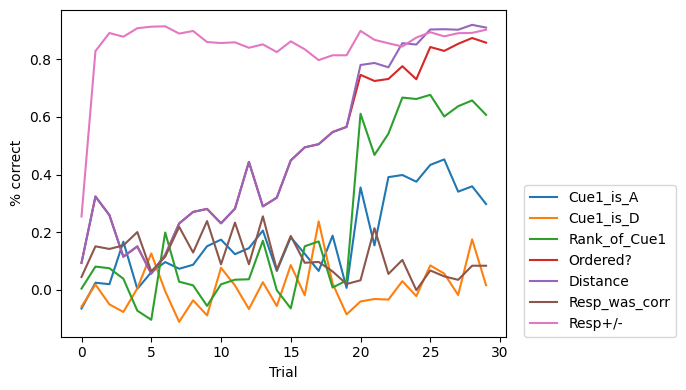

In [18]:
plt.figure(figsize=(7,4))
plt.plot(curves, label=['Cue1_is_A', 'Cue1_is_D', 'Rank_of_Cue1', 'Ordered?', 'Distance', 'Resp_was_corr', 'Resp+/-'])
plt.xlabel('Trial')
plt.ylabel('% correct')
plt.legend(loc=(1.04,0))
plt.tight_layout()
plt.savefig('decoding.png',dpi=300)


In [19]:

# Decoding "ordered" is easy late  in the episode, of course, so the system works,,,
# model = sklearn.neural_network.MLPClassifier(activation='tanh', hidden_layer_sizes=[100,], max_iter=2000)
# model = sklearn.neural_network.MLPRegressor (activation='tanh', hidden_layer_sizes=[100,], max_iter=2000)
model =  sklearn.linear_model.LinearRegression()
curvenn = np.zeros(params['nbtrials'])
# curvennother = np.zeros(params['nbtrials'])
ynn = first_iscuenum[3, :, :]
# ynnother = first_iscuenum[4, :, :]
# ynn = ordered
NUMTRIAL = 19
POSINTRIALTRAIN = 0
POSINTRIALTEST = 1
mxtrain= allrates[:,  :, POSINTRIALTRAIN::params['triallen']]
mxtest= allrates[:,  :, POSINTRIALTEST::params['triallen']]
for NUMTRIAL  in range(params['nbtrials']):
    if NUMTRIAL %  6 == 0:
        print(NUMTRIAL)
        model.fit(mxtrain[:-200,:,NUMTRIAL], ynn[:-200, NUMTRIAL])
        out = model.predict(mxtest[-200:, :,NUMTRIAL])
        # print(out[:10])  # Might be all 0s!
        curvenn[NUMTRIAL] = np.corrcoef(out.T[:], ynn[-200:, NUMTRIAL].T)[0,1]
        # curvennother[NUMTRIAL] = np.corrcoef(out.T[:], ynnother[-200:, NUMTRIAL].T)[0,1]
    else:
            curvenn[NUMTRIAL] = curvenn[NUMTRIAL-1]
            # curvennother[NUMTRIAL] = curvennother[NUMTRIAL-1]
print(curvenn)
# print(curvennother)

0
6
12
18
24
[ 0.00206  0.00206  0.00206  0.00206  0.00206  0.00206  0.05226  0.05226
  0.05226  0.05226  0.05226  0.05226  0.0321   0.0321   0.0321   0.0321
  0.0321   0.0321   0.02585  0.02585  0.02585  0.02585  0.02585  0.02585
 -0.03399 -0.03399 -0.03399 -0.03399 -0.03399 -0.03399]


In [20]:
print(a.shape, first_iscuenum.shape)
POSINTRIAL =  1
NUMTRIAL = 19
rates = allrates[:, :, POSINTRIAL::params['triallen']]
rates = rates[:, :, NUMTRIAL]
rates = rates -  np.mean(rates, axis=0)[None,  :]
rates2 = np.mean(rates[first_iscuenum[2, :, NUMTRIAL] == 1, :], axis=0)
rates3 = np.mean(rates[first_iscuenum[3, :, NUMTRIAL] == 1, :], axis=0)
rates4 = np.mean(rates[first_iscuenum[4, :, NUMTRIAL] == 1, :], axis=0)
rates5 = np.mean(rates[first_iscuenum[5, :, NUMTRIAL] == 1, :], axis=0)
rates6 = np.mean(rates[first_iscuenum[6, :, NUMTRIAL] == 1, :], axis=0)
rates7 = np.mean(rates[first_iscuenum[7, :, NUMTRIAL] == 1, :], axis=0)
print(np.corrcoef(rates2, rates3))
print(np.corrcoef(rates2, rates4))
print(np.corrcoef(rates2, rates5))
print(np.corrcoef(rates2, rates6))
print(np.corrcoef(rates2, rates7))



(2000, 200, 120) (8, 2000, 30)
[[1.      0.19641]
 [0.19641 1.     ]]
[[ 1.      -0.63629]
 [-0.63629  1.     ]]
[[ 1.      -0.57396]
 [-0.57396  1.     ]]
[[ 1.      -0.65386]
 [-0.65386  1.     ]]
[[1.      0.78374]
 [0.78374 1.     ]]


(2000, 200, 30)
(2000, 7, 30)
(2000, 30)
(8, 2000, 30)
(2000, 30)
(2000, 30)
(2000, 50)
Variance explained for each successive PC: [0.26189 0.03697 0.03485 0.03449 0.03065 0.02951 0.02834 0.02811 0.02698
 0.02565 0.02445 0.02346 0.02299 0.02173 0.02024 0.01956 0.01697 0.01363
 0.01115 0.01006 0.00851 0.00801 0.00754 0.00674 0.00624 0.00565 0.00541
 0.00528 0.00509 0.00474 0.00471 0.00456 0.0043  0.00415 0.00413 0.00382
 0.00378 0.00355 0.00341 0.00336 0.00325 0.00316 0.00312 0.00302 0.00301
 0.00288 0.00279 0.00273 0.00261 0.00252]


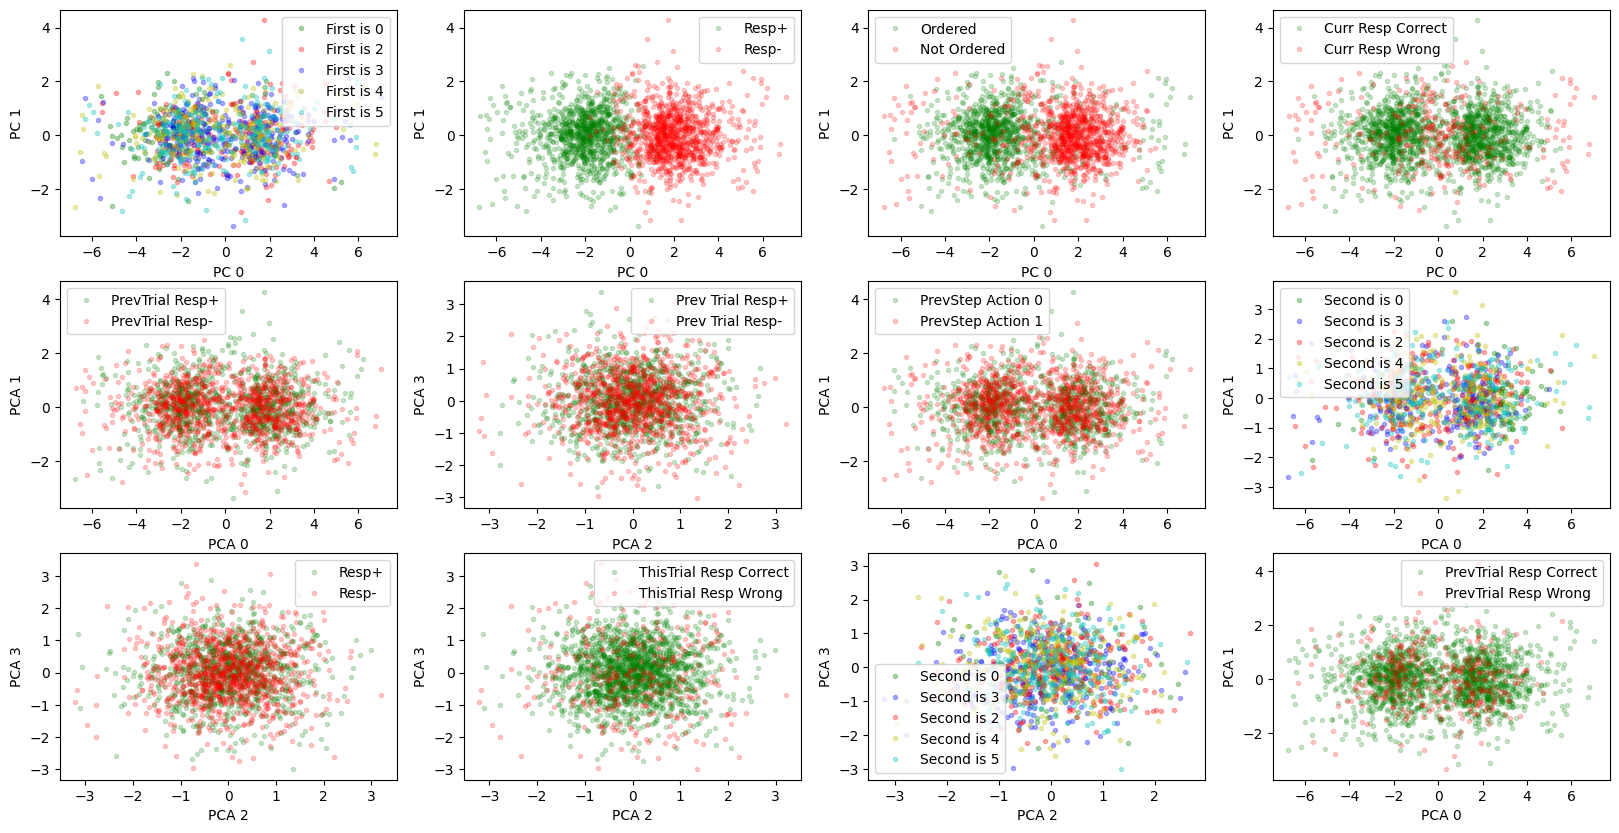

In [21]:
print(x.shape)  #  5000 (BS * NbEpisodes), 200 (NbNeurons), 32 (NbTrials)
print(yall.shape)  #  5000 (BBS * NbEpisodes), 5 (number of different quantities), 32 (NbTrials)
print(yall[:, 1,  :].shape)
print(first_iscuenum.shape)  # 8 (numbber of different cues),  5000 (BS * NbEpisodes), 32 (NbTrials)
print(ordered.shape)  # 5000 (BS * NbEpisodes), 32  (NbTrials)
print(corr.shape)  # 5000 (BS * NbEpisodes), 32  (NbTrials)



NUMTRIALPCA =  19 # 21 #  34
POSINTRIALPCA = 1

# mx = x[:,:, NUMTRIAL]
mxp= allrates[:,  :, POSINTRIALPCA::params['triallen']]
mx = mxp[:,:, NUMTRIALPCA]

# mx  = mx - np.mean(mx, axis=0)[None, :]
# mx  =  mx / (1e-8 + np.std(mx, axis=0)[None, :])


MAX = 300

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
mx_pca =pca.fit_transform(mx)
print(mx_pca.shape)    # 5000  (BS * NbEpisodes), 2 (Numberr of PCA components)
print("Variance explained for each successive PC:", pca.explained_variance_ratio_)

plt.figure(figsize=(20,10))
plt.subplot(3,4,1)
mx_pca_firstis0 = mx_pca[first_iscuenum[0, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis0[:, 0], mx_pca_firstis0[:, 1], '.g', alpha=.3, label='First is 0')
mx_pca_firstis2 = mx_pca[first_iscuenum[2, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis2[:, 0], mx_pca_firstis2[:, 1], '.r', alpha=.3, label='First is 2')
mx_pca_firstis3 = mx_pca[first_iscuenum[3, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis3[:, 0], mx_pca_firstis3[:, 1], '.b', alpha=.3, label='First is 3')
mx_pca_firstis4 = mx_pca[first_iscuenum[4, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis4[:, 0], mx_pca_firstis4[:, 1], '.y', alpha=.3, label='First is 4')
mx_pca_firstis5 = mx_pca[first_iscuenum[5, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis5[:, 0], mx_pca_firstis5[:, 1], '.c', alpha=.3, label='First is 5')
plt.xlabel('PC 0'); plt.ylabel('PC 1')
plt.legend()


# mx_pca_firstis1 = mx_pca[first_iscuenum[1, :, NUMTRIAL] == 1, :]
# plt.plot(mx_pca_firstis1[:, 0], mx_pca_firstis1[:, 1], '.')
# mx_pca_firstis2 = mx_pca[first_iscuenum[2, :, NUMTRIAL] == 1, :]
# plt.plot(mx_pca_firstis2[:, 0], mx_pca_firstis2[:, 1], '.')
# mx_pca_firstis4 = mx_pca[first_iscuenum[4, :, NUMTRIAL] == 1, :]
# plt.plot(mx_pca_firstis4[:, 0], mx_pca_firstis4[:, 1], '.')
# mx_pca_firstis5 = mx_pca[first_iscuenum[5, :, NUMTRIAL] == 1, :]
# plt.plot(mx_pca_firstis5[:, 0], mx_pca_firstis5[:, 1], '.')
# mx_pca_firstis6 = mx_pca[first_iscuenum[6, :, NUMTRIAL] == 1, :]
# plt.plot(mx_pca_firstis6[:, 0], mx_pca_firstis6[:, 1], '.')




plt.subplot(3,4,2)
respPpoints = mx_pca[resps[:, NUMTRIALPCA] == 1, :]
plt.plot(respPpoints[:, 0], respPpoints[:, 1], '.g', alpha=.2, label='Resp+')

respNpoints = mx_pca[resps[:, NUMTRIALPCA] == -1, :]
plt.plot(respNpoints[:, 0], respNpoints[:, 1], '.r', alpha=.2, label='Resp-')
plt.xlabel('PC 0'); plt.ylabel('PC 1')
plt.legend()




plt.subplot(3,4,3)
orderedpoints = mx_pca[ordered[:, NUMTRIALPCA] == 1, :]
plt.plot(orderedpoints[:, 0], orderedpoints[:, 1], '.g', alpha=.2, label='Ordered')

notorderedpoints = mx_pca[ordered[:, NUMTRIALPCA] == 0, :]
plt.plot(notorderedpoints[:, 0], notorderedpoints[:, 1], '.r', alpha=.2, label='Not Ordered')
plt.xlabel('PC 0'); plt.ylabel('PC 1')
plt.legend()


plt.subplot(3,4,4)
currcorrpoints = mx_pca[corr[:, NUMTRIALPCA] == 1, :]
plt.plot(currcorrpoints[:, 0], currcorrpoints[:, 1], '.g', alpha=.2, label='Curr Resp Correct')

currnotcorrpoints = mx_pca[corr[:, NUMTRIALPCA] == 0, :]
plt.plot(currnotcorrpoints[:, 0], currnotcorrpoints[:, 1], '.r', alpha=.2, label='Curr Resp Wrong')
plt.xlabel('PC 0'); plt.ylabel('PC 1')
plt.legend()


plt.subplot(3,4,5)



prevcorrpoints = mx_pca[resps[:, NUMTRIALPCA-1] == 1, :]
plt.plot(prevcorrpoints[:, 0], prevcorrpoints[:, 1], '.g', alpha=.2, label='PrevTrial Resp+')
prevnotcorrpoints = mx_pca[resps[:, NUMTRIALPCA-1] == -1, :]
plt.plot(prevnotcorrpoints[:, 0], prevnotcorrpoints[:, 1], '.r', alpha=.2, label='PrevTrial Resp-')
plt.xlabel('PCA 0'); plt.ylabel('PCA 1')
plt.legend()




plt.subplot(3,4,6)
prespPpoints = mx_pca[resps[:, NUMTRIALPCA-1] == 1, :]
plt.plot(prespPpoints[:, 2], prespPpoints[:, 3], '.g', alpha=.2, label='Prev Trial Resp+')
prespNpoints = mx_pca[resps[:, NUMTRIALPCA-1] == -1, :]
plt.plot(prespNpoints[:, 2], prespNpoints[:, 3], '.r', alpha=.2, label='Prev Trial Resp-')
plt.xlabel('PCA 2'); plt.ylabel('PCA 3')
plt.legend()

plt.subplot(3,4,7)
preva0points = mx_pca[ac[:, NUMTRIALPCA, POSINTRIALPCA-1] == 0, :]
plt.plot(preva0points[:, 0], preva0points[:, 1], '.g', alpha=.2, label='PrevStep Action 0')
preva1points = mx_pca[ac[:, NUMTRIALPCA, POSINTRIALPCA-1] == 1, :]
plt.plot(preva1points[:, 0], preva1points[:, 1], '.r', alpha=.2, label='PrevStep Action 1')
plt.xlabel('PCA 0'); plt.ylabel('PCA 1')
plt.legend()


plt.subplot(3,4,8)
mx_pca_secondis0 = mx_pca[second_iscuenum[0, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis0[:, 0], mx_pca_secondis0[:, 1], '.g', alpha=.3, label='Second is 0')
mx_pca_secondis3 = mx_pca[second_iscuenum[3, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis3[:, 0], mx_pca_secondis3[:, 1], '.b', alpha=.3, label='Second is 3')
mx_pca_secondis2 = mx_pca[second_iscuenum[2, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis2[:, 0], mx_pca_secondis2[:, 1], '.r', alpha=.3, label='Second is 2')
mx_pca_secondis4 = mx_pca[second_iscuenum[4, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis4[:, 0], mx_pca_secondis4[:, 1], '.y', alpha=.3, label='Second is 4')
mx_pca_secondis5 = mx_pca[second_iscuenum[5, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis5[:, 0], mx_pca_secondis5[:, 1], '.c', alpha=.3, label='Second is 5')
plt.xlabel('PCA 0'); plt.ylabel('PCA 1')
plt.legend()


# plt.subplot(3,4,8)
# mx_pca_secondis0 = mx_pca[second_iscuenum[0, :, NUMTRIAL-1] == 1, :]
# plt.plot(mx_pca_secondis0[:, 4], mx_pca_secondis0[:, 3], '.g', alpha=.3, label='Prev Second is 0')
# mx_pca_secondis3 = mx_pca[second_iscuenum[3, :, NUMTRIAL-1] == 1, :]
# plt.plot(mx_pca_secondis3[:, 4], mx_pca_secondis3[:, 3], '.b', alpha=.3, label='Prev Second is 3')
# mx_pca_secondis2 = mx_pca[second_iscuenum[2, :, NUMTRIAL-1] == 1, :]
# plt.plot(mx_pca_secondis2[:, 4], mx_pca_secondis2[:, 3], '.r', alpha=.3, label='Prev Second is 2')
# mx_pca_secondis4 = mx_pca[second_iscuenum[4, :, NUMTRIAL-1] == 1, :]
# plt.plot(mx_pca_secondis4[:, 4], mx_pca_secondis4[:, 3], '.y', alpha=.3, label='Prev Second is 4')
# mx_pca_secondis5 = mx_pca[second_iscuenum[5, :, NUMTRIAL-1] == 1, :]
# plt.plot(mx_pca_secondis5[:, 4], mx_pca_secondis5[:, 3], '.c', alpha=.3, label='Prev Second is 5')
# plt.xlabel('PCA 4'); plt.ylabel('PCA 3')
# plt.legend()



plt.subplot(3,4,9)
respPpoints = mx_pca[resps[:, NUMTRIALPCA] == 1, :]
plt.plot(respPpoints[:, 2], respPpoints[:, 3], '.g', alpha=.2, label='Resp+')

respNpoints = mx_pca[resps[:, NUMTRIALPCA] == -1, :]
plt.plot(respNpoints[:, 2], respNpoints[:, 3], '.r', alpha=.2, label='Resp-')
plt.xlabel('PCA 2'); plt.ylabel('PCA 3')
plt.legend()



plt.subplot(3,4,10)
prevcorrpoints = mx_pca[corr[:, NUMTRIALPCA] == 1, :]
plt.plot(prevcorrpoints[:, 2], prevcorrpoints[:, 3], '.g', alpha=.2, label='ThisTrial Resp Correct')
prevnotcorrpoints = mx_pca[corr[:, NUMTRIALPCA] == 0, :]
plt.plot(prevnotcorrpoints[:, 2], prevnotcorrpoints[:, 3], '.r', alpha=.2, label='ThisTrial Resp Wrong')
plt.xlabel('PCA 2'); plt.ylabel('PCA 3')
plt.legend()

# plt.subplot(3,4,10)
# prevcorrpoints = mx_pca[corr[:, NUMTRIAL-1] == 1, :]
# plt.plot(prevcorrpoints[:, 2], prevcorrpoints[:, 3], '.g', alpha=.2, label='PrevTrial Resp Correct')
# prevnotcorrpoints = mx_pca[corr[:, NUMTRIAL-1] == 0, :]
# plt.plot(prevnotcorrpoints[:, 2], prevnotcorrpoints[:, 3], '.r', alpha=.2, label='PrevTrial Resp Wrong')
# plt.xlabel('PCA 2'); plt.ylabel('PCA 3')
# plt.legend()


plt.subplot(3,4,11)
mx_pca_secondis0 = mx_pca[second_iscuenum[0, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis0[:, 2], mx_pca_secondis0[:, 3], '.g', alpha=.3, label='Second is 0')
mx_pca_secondis3 = mx_pca[second_iscuenum[3, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis3[:, 2], mx_pca_secondis3[:, 3], '.b', alpha=.3, label='Second is 3')
mx_pca_secondis2 = mx_pca[second_iscuenum[2, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis2[:, 2], mx_pca_secondis2[:, 3], '.r', alpha=.3, label='Second is 2')
mx_pca_secondis4 = mx_pca[second_iscuenum[4, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis4[:, 2], mx_pca_secondis4[:, 3], '.y', alpha=.3, label='Second is 4')
mx_pca_secondis5 = mx_pca[second_iscuenum[5, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_secondis5[:, 2], mx_pca_secondis5[:, 3], '.c', alpha=.3, label='Second is 5')
plt.xlabel('PCA 2'); plt.ylabel('PCA 3')
plt.legend()

plt.subplot(3,4,12)
prevcorrpoints = mx_pca[corr[:, NUMTRIALPCA-1] == 1, :]
plt.plot(prevcorrpoints[:, 0], prevcorrpoints[:, 1], '.g', alpha=.2, label='PrevTrial Resp Correct')
prevnotcorrpoints = mx_pca[corr[:, NUMTRIALPCA-1] == 0, :]
plt.plot(prevnotcorrpoints[:, 0], prevnotcorrpoints[:, 1], '.r', alpha=.2, label='PrevTrial Resp Wrong')
plt.xlabel('PCA 0'); plt.ylabel('PCA 1')
plt.legend()


In [22]:
# If the PCA was done on numstep 1 (response step), the first PC / eigenv, which represents 'decision', should be strongly aligned with the input weights of the network's output head
wo = net.h2o.weight.cpu().numpy()
print("Correlation between the two rows of Wout:")
print(np.corrcoef(wo[0,:], wo[1,:]))


wo =  wo[1,:]  - wo[0,:]
print("Correlation between Wout and PC1:")
print(np.corrcoef(wo, pca.components_[0,:]))

print("Correlation between Win for each cue")
wi = net.i2h.weight.cpu().numpy()
print(wi.shape)
wi1 = wi[:,:params['cs']].flatten()
wi2 = wi[:,params['cs']:2*params['cs']].flatten()
print(np.corrcoef(wi1, wi2))



Correlation between the two rows of Wout:
[[ 1.      -0.90403]
 [-0.90403  1.     ]]
Correlation between Wout and PC1:
[[ 1.      -0.94157]
 [-0.94157  1.     ]]
Correlation between Win for each cue
(200, 37)
[[ 1.      -0.81248]
 [-0.81248  1.     ]]


In [23]:

wo = net.h2o.weight.cpu().numpy()
wo  =wo[1,:] - wo[0,:]
print(wo.shape)

woPCA  = pca.transform(wo[None, :])[0,:]
print(woPCA.shape)
print(woPCA[:4])



(200,)
(50,)
[-3.44719 -0.29595  0.0185  -0.07624]


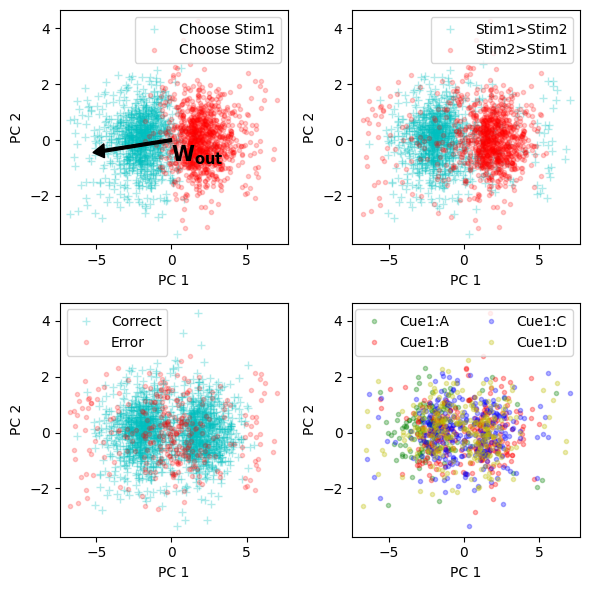

In [24]:


plt.figure(figsize=(6,6))



plt.subplot(2,2,1)


respPpoints = mx_pca[resps[:, NUMTRIALPCA] == 1, :]
plt.plot(respPpoints[:, 0], respPpoints[:, 1], '+c', alpha=.3, label='Choose Stim1')

respNpoints = mx_pca[resps[:, NUMTRIALPCA] == -1, :]
plt.plot(respNpoints[:, 0], respNpoints[:, 1], '.r', alpha=.2, label='Choose Stim2')
plt.xlabel('PC 1'); plt.ylabel('PC 2')


# Arrrow represents the output weights vector
# Direction of  arrow (left/right) is random....but it should point towards the blue crosses (positive response) !

arrlength = 1.3
plt.arrow(0, 0, arrlength * woPCA[0], arrlength * woPCA[1], color='k', zorder=10,  width=.1, head_width=.5)#, label='$\mathbf{W}_{out}$')
# plt.text(-3.5, -.6, '$\mathbf{W}_{out}$', fontsize=15)
plt.text(0, -.75, '$\mathbf{W_{out}}$', fontsize=15)

plt.legend()




plt.subplot(2,2,2)
orderedpoints = mx_pca[ordered[:, NUMTRIALPCA] == 1, :]
plt.plot(orderedpoints[:, 0], orderedpoints[:, 1], '+c', alpha=.3, label='Stim1>Stim2')

notorderedpoints = mx_pca[ordered[:, NUMTRIALPCA] == 0, :]
plt.plot(notorderedpoints[:, 0], notorderedpoints[:, 1], '.r', alpha=.2, label='Stim2>Stim1')
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend()


plt.subplot(2,2,3)


currcorrpoints = mx_pca[corr[:, NUMTRIALPCA] == 1, :]
plt.plot(currcorrpoints[:, 0], currcorrpoints[:, 1], '+c', alpha=.3, label='Correct')

currnotcorrpoints = mx_pca[corr[:, NUMTRIALPCA] == 0, :]
plt.plot(currnotcorrpoints[:, 0], currnotcorrpoints[:, 1], '.r', alpha=.2, label='Error')
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend()





plt.subplot(2,2,4)

mx_pca_firstis0 = mx_pca[first_iscuenum[0, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis0[:, 0], mx_pca_firstis0[:, 1], '.g', alpha=.3, label='Cue1:A')
mx_pca_firstis2 = mx_pca[first_iscuenum[2, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis2[:, 0], mx_pca_firstis2[:, 1], '.r', alpha=.3, label='Cue1:B')
mx_pca_firstis3 = mx_pca[first_iscuenum[3, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis3[:, 0], mx_pca_firstis3[:, 1], '.b', alpha=.3, label='Cue1:C')
mx_pca_firstis4 = mx_pca[first_iscuenum[4, :, NUMTRIALPCA] == 1, :]
plt.plot(mx_pca_firstis4[:, 0], mx_pca_firstis4[:, 1], '.y', alpha=.3, label='Cue1:D')
# mx_pca_firstis5 = mx_pca[first_iscuenum[5, :, NUMTRIALPCA] == 1, :]
# plt.plot(mx_pca_firstis5[:, 0], mx_pca_firstis5[:, 1], '.c', alpha=.3, label='Cue1=E')
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend(ncol=2)

# plt.gcf().suptitle("PCA of $\mathbf{r}(t=2)$, trial 20, 2000 runs")

plt.tight_layout()

plt.savefig('PCA.png', dpi=300)



In [25]:
# Extracting the patterns produced in hidden neurons by  each individual cue when presented as 1st cue, on step 0 (i.e. without any recurrence)

#  NOTE: This is only useful across batch if we use fixed  cues !
BS2 = 10

inputs = np.zeros((BS2, params['inputsize']), dtype='float32')

for nb in range(params['nbcues']):
    # Turning the cue number for this time step into actual (signed) bitstring inputs, using the cue  data generated at the beginning of the episode - or, ocasionally, oldcuedata
    inputs[nb, :NBSTIMBITS] = 0
    inputs[nb, :params['cs']] = cuedata[0][nb][:]

    inputs[nb, NBSTIMBITS + 0] = 1.0 # Bias neuron, probably not necessary
    inputs[nb,NBSTIMBITS +  1] = 0 #numstep_ep / params['eplen'] # Time passed in this episode. Should it be the trial? Doesn't matter much anyway.
    inputs[nb, NBSTIMBITS + 2] = 0 # 1.0 * reward[nb] # Reward from previous time step

    # if numstep == 0 and numtrial > 0:
    #     inputs[nb, NBSTIMBITS + ADDINPUT + numactionschosen[nb]] = 1  # Previously chosen action


# inputsC = torch.from_numpy(inputs, requires_grad=False).to(device)
inputsN = torch.from_numpy(inputs).detach().to(device)

hidden = net.initialZeroState(BS2)
et = net.initialZeroET(BS2) #  The Hebbian eligibility trace
pw = net.initialZeroPlasticWeights(BS2)

y, v, DAout, cue1patterns, et, pw  = net(inputsN, hidden, et, pw)  # y  should output raw scores, not probas

print(cue1patterns.shape)  #  500, 200
cue1patterns = cue1patterns[:params['nbcues'], :].cpu().numpy()


torch.Size([10, 200])


In [26]:
# *Single* cues, after one step of recurrence, are projected along the "decision" axis (which matches the output weights) at their appropriate rank.

# You can't decode the rank of either 1st oe 2nd cue from neuron firing in normal network operation, because then the network sees both the first and the second cue as one and
# (becausethe input weights for both cues are mirror images of each other) reflect the *difference* between the two cues
# which is exactly what  is needed for decision)

# NOTE: This uses the specific representation of the nb'th cue in the nb'th network so it doesn't require fixed cues, but it's very noisy ofc
# because the pw of only 1 batch element are used to assess corrrelatioin of step-1 repres of each cue with wo

BS2 = 10
inputs = np.zeros((BS2, params['inputsize']), dtype='float32')
for nb in range(params['nbcues']):
    inputs[nb, :NBSTIMBITS] = 0
    # inputs[nb, :params['cs']] = cuedata[0][nb][:]
    inputs[nb, :params['cs']] = cuedata[nb][nb][:]
    inputs[nb, NBSTIMBITS + 0] = 1.0 # Bias neuron, probably not necessary
    inputs[nb,NBSTIMBITS +  1] = 0 #numstep_ep / params['eplen'] # Time passed in this episode. Should it be the trial? Doesn't matter much anyway.
    inputs[nb, NBSTIMBITS + 2] = 0 # 1.0 * reward[nb] # Reward from previous time step
inputsN0 = torch.from_numpy(inputs).detach().to(device)
inputsN1 = inputsN0.clone()
inputsN1[:, :NBSTIMBITS] = 0   # Normally, stimuli are only presented at the first time step

hidden = net.initialZeroState(BS2)
et = net.initialZeroET(BS2) #  The Hebbian eligibility trace

# pwsav = pwsav29.clone()
pwsav = allpwsavs_thisep[19*params['triallen']][:BS2, :].copy()
pwtest = torch.from_numpy(pwsav).to(device)

# TESTNB = 0
# pwtest[:,:,:] = pwsav[TESTNB,:,:][None,:,:]
# print("These should all be identical:")
# print(pwtest[0,7,:10])
# print(pwtest[1,7,:10])
# print(pwsav[5,7,:10])

y, v, DAout, hidden, et, pw  = net(inputsN0, hidden, et, pwtest)
y, v, DAout, hiddenout, et, pw  = net(inputsN1, hidden, et, pw)

hiddenout  = hiddenout.cpu().numpy()

wo = net.h2o.weight.cpu().numpy()
wo = wo[1,:] - wo[0,:] # output weight vector
print("Correlation of step-1 representation of each cue with output-weights vector\n(after training period) (FOR THE PW OF A SINGLE BATCH ELEMENT!) (very noisy due to not averaging overr batch):")
for nb in range(params['nbcues']):
    print("Cue", nb, ":", np.corrcoef(hiddenout[nb,:], wo)[0,1])#, np.sum(hiddenout[nb,:]**2)  np.sum(hiddenout[nb,:] * wo) / np.sqrt(np.sum(wo ** 2)), np.sum(hiddenout[nb,:] * wo) / (np.sqrt(np.sum(wo ** 2)) * np.sqrt(sum(hiddenout[nb,:]**2))))
# print(cp[TESTNB,19:22,:].T)



Correlation of step-1 representation of each cue with output-weights vector
(after training period) (FOR THE PW OF A SINGLE BATCH ELEMENT!) (very noisy due to not averaging overr batch):
Cue 0 : -0.02986510331039328
Cue 1 : 0.373133761797768
Cue 2 : 0.04856209957123041
Cue 3 : -0.29733164006732454
Cue 4 : 0.13960799122483786
Cue 5 : -0.4068303621310507
Cue 6 : -0.292992370083319
Cue 7 : -0.624060817199945


In [27]:
# Extracting the patterns produced in hidden neurons by  each individual cue when presented as 1st cue, on step 0 (i.e. without any recurrence)

# For  each  batch element separately ! No need  for fixed cues


tic =time.time()
MYBS = params['bs']

inputs = np.zeros((params['bs'], params['inputsize']), dtype='float32')
cuedata_arr= np.array(cuedata)
# raise ValueError

print("Extracting  step-0 (feedforward) representations of all cues, for each batchelement (they  differ because each batchelement has its own randomly generated cues)")

cue1patternsallbatch = []
for nb in range(params['nbcues']):
    print("Cue", nb)
    # Turning the cue number for this time step into actual (signed) bitstring inputs, using the cue  data generated at the beginning of the episode - or, ocasionally, oldcuedata
    inputs[:, :NBSTIMBITS] = 0
    inputs[:, :params['cs']] = cuedata_arr[:, nb,  :]

    inputs[:, NBSTIMBITS + 0] = 1.0 # Bias neuron, probably not necessary
    inputs[:,NBSTIMBITS +  1] = 0 #numstep_ep / params['eplen'] # Time passed in this episode. Should it be the trial? Doesn't matter much anyway.
    inputs[:, NBSTIMBITS + 2] = 0 # 1.0 * reward[nb] # Reward from previous time step

    inputsN = torch.from_numpy(inputs).detach().to(device)

    hidden = net.initialZeroState(MYBS)
    et = net.initialZeroET(MYBS) #  The Hebbian eligibility trace
    pw = net.initialZeroPlasticWeights(MYBS)

    y, v, DAout, hidden, et, pw  = net(inputsN, hidden, et, pw)  # y  should output raw scores, not probas
    cue1patternsallbatch.append(hidden.cpu().numpy())

print("Time taken:", time.time()-tic)


Extracting  step-0 (feedforward) representations of all cues, for each batchelement (they  differ because each batchelement has its own randomly generated cues)
Cue 0
Cue 1
Cue 2
Cue 3
Cue 4
Cue 5
Cue 6
Cue 7
Time taken: 4.54018759727478


In [28]:
# *Single* cues, after one step of recurrence, are projected along the "decision" axis (which matches the output weights) at their appropriate rank.

# You can't decode the rank of either 1st oe 2nd cue from neuron firing in normal network operation, because then the network sees both the first and the second cue as one and
# (becausethe input weights for both cues are mirror images of each other) reflect the *difference* between the two cues
# which is exactly what  is needed for decision)

# NOTE: This uses the specific representation of the nb'th cue in the nb'th network so it doesn't require fixed cues
MYBS = params['bs']

inputs = np.zeros((params['bs'], params['inputsize']), dtype='float32')
cuedata_arr= np.array(cuedata)
# raise ValueError

pwsav = allpwsavs_thisep[19*params['triallen']].copy()
pwtest = torch.from_numpy(pwsav).to(device)

wo = net.h2o.weight.cpu().numpy()
wo =wo[1,:] - wo[0,:]

allcorrs = []
print("Mean (across batch) correlation of step-1 representation of each cue with output-weights vector\n(trial 20):")

for nb in range(params['nbcues']):
    # Turning the cue number for this time step into actual (signed) bitstring inputs, using the cue  data generated at the beginning of the episode - or, ocasionally, oldcuedata
    inputs[:, :NBSTIMBITS] = 0
    inputs[:, :params['cs']] = cuedata_arr[:, nb,  :]

    inputs[:, NBSTIMBITS + 0] = 1.0 # Bias neuron, probably not necessary
    inputs[:,NBSTIMBITS +  1] = 0 #numstep_ep / params['eplen'] # Time passed in this episode. Should it be the trial? Doesn't matter much anyway.
    inputs[:, NBSTIMBITS + 2] = 0 # 1.0 * reward[nb] # Reward from previous time step

    inputsN0 = torch.from_numpy(inputs).detach().to(device)
    inputsN1 = inputsN0.clone()
    inputsN1[:, :NBSTIMBITS] = 0   # Normally, stimuli are only presented at the first time step

    hidden = net.initialZeroState(MYBS)
    et = net.initialZeroET(MYBS) #  The Hebbian eligibility trace
    pw = net.initialZeroPlasticWeights(MYBS)

    y, v, DAout, hidden, et, pw  = net(inputsN0, hidden, et, pwtest)
    y, v, DAout, hiddenout, et, pw  = net(inputsN1, hidden, et, pw)

    hiddenout  = hiddenout.cpu().numpy()
    z  = np.corrcoef(hiddenout, wo)  # Very wasteful, computes correlations between all  the  hiddenouts in the batch! But so be it.
    z = z[:-1,-1]   # Last item is always 1.0
    print("Cue", nb, ":", np.mean(z))

    allcorrs.append(z)


allcorrs = np.array(allcorrs)

Mean (across batch) correlation of step-1 representation of each cue with output-weights vector
(trial 20):
Cue 0 : 0.5064298981953599
Cue 1 : 0.3201739836449595
Cue 2 : 0.1506090495048552
Cue 3 : 0.04201594092094996
Cue 4 : -0.02595224884214945
Cue 5 : -0.14769283141728004
Cue 6 : -0.3201839271557547
Cue 7 : -0.5032294796213836


Correlation between the step-2 (learned) representation of each individual cue, and the output weight vector w_out
(8, 2000)


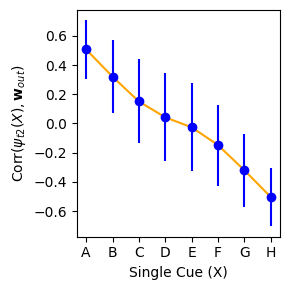

In [29]:
print("Correlation between the step-2 (learned) representation of each individual cue, and the output weight vector w_out")
print(allcorrs.shape)  # 8, 2000

plt.figure(figsize=(3,3))
plt.xticks(np.arange(8), alphabet[:8])
plt.plot(np.array(np.mean(allcorrs, axis=1)), 'orange')
plt.errorbar(np.arange(8), np.mean(allcorrs, axis=1),yerr=np.std(allcorrs, axis=1),color='b', marker='o', linestyle='none')
plt.xlabel("Single Cue (X)")
plt.ylabel("Corr($\psi_{t2}(X), \mathbf{w}_{out}$)")
plt.tight_layout()

plt.savefig("cuecorrs.png", dpi=300)

In [30]:
print("Plotting the change in alignment between step-2 cue representation and wout, step by step, for each cue")

MYBS = params['bs']


# At which trial are we going to assess the changes in correlation?
NUMTRIALCHNGCORR = 18  # 5 or 6 or 18 or 19, because only data from trials 5,6, 18 and 19 are stored in the main code cell. Paper uses 18. 19 should have fewer data points if we select those that didn't see the central pair before that, obviously (and if we don't use HALFNOBARREDPAIRUNTILT18) - but it works.
# NUMTRIALCHNGCORR = 19  # 5 or 6 or 18 or 19, because only  trials 5,6, 18 and 19  are stored in the main cell



np.set_printoptions(linewidth=np.inf)

# We select the runs where the cue pair at trial NUMTRIALCHNGCORR was 4&3 or 3&4, AND it was not shown  in any of the previous trials (i.e. the "spontaneous list linking" episodes)
# (response for such trials will invariably be wrong, I think)

selectpair = BARREDPAIR

# ADDBARREDPAIR = [BARREDPAIR[0]-1, BARREDPAIR[0]]
ADDBARREDPAIR = [BARREDPAIR[1], BARREDPAIR[1]+1]


selects = []
for nb in range(MYBS):
    include = True
    if selectpair[0] not in cp[nb, NUMTRIALCHNGCORR,:] or selectpair[1] not in cp[nb, NUMTRIALCHNGCORR,:]:
        include = False
    else:
        for nt in range(NUMTRIALCHNGCORR):   # going to NUMTRIALCHNGCORR - 1 incl.
            if cp[nb, nt, 0] in selectpair and cp[nb, nt, 1] in  selectpair:
                include = False
                break
    if include:
        selects.append(nb)
print(len(selects))
print(selects)


# Additionally, from all these, we separately select those where the pair juust beforre OR just after the main barrred pair  was  also not  shown before
selectsadd = []
for nb in selects:
    include = True
    for nt in range(NUMTRIALCHNGCORR):   # going to NUMTRIALCHNGCORR - 1 incl.
        if cp[nb, nt, 0] in [ADDBARREDPAIR[0],ADDBARREDPAIR[1]] and cp[nb, nt, 1] in  [ADDBARREDPAIR[0],ADDBARREDPAIR[1]] : # Any order would cause pairing.
            include = False
            break
    if include:
        selectsadd.append(nb)
print(len(selectsadd))
print(selectsadd)


NUMBECHNGCORR = selects[0]  # NUMBE = "Number (index) of the batch element"



print("Cue pairs for batch element", NUMBECHNGCORR, ":")
print(np.hstack((cp[NUMBECHNGCORR,:,:], np.arange(cp.shape[1])[:, None])).T)

MYBS = params['bs']

ds= ds_thisep.copy()
rs = rs_thisep.copy()

inputs = np.zeros((params['bs'], params['inputsize']), dtype='float32')
cuedata_arr= np.array(cuedata)

torch.set_grad_enabled(False)

# wo = net.h2o.weight.cpu().numpy()[0,:] # output weights
wo = net.h2o.weight.cpu().numpy()
wo = wo[1,:] - wo[0,:] # output weight vector

oldvals = [''] * 8

myselects = selects
# myselects = selectsadd

corrseachstep = []


for numstep in range(4):
    actualnumstep = NUMTRIALCHNGCORR * params['triallen'] + numstep
    print("Actual step:", actualnumstep)
    pwsavfull = allpwsavs_thisep[actualnumstep]
    pwtest = torch.from_numpy(pwsavfull).to(device)
    corrsthiscue  = []
    for nbcue in range(8):

        # We run the network for two time steps, using the stored plastic weights in pwtest, so we can extract the step-2 representation of each single cue, as encoded
        # by the successive states of the plastic weights over the 4 time steps of the trial

        hidden = net.initialZeroState(MYBS)
        et = net.initialZeroET(MYBS) #  The Hebbian eligibility trace

        inputs[:, :NBSTIMBITS] = 0
        inputs[:, :params['cs']] = cuedata_arr[:, nbcue,  :]

        inputs[:, NBSTIMBITS + 0] = 1.0 # Bias neuron, probably not necessary
        inputs[:,NBSTIMBITS +  1] = 0 #numstep_ep / params['eplen'] # Time passed in this episode. Should it be the trial? Doesn't matter much anyway.
        inputs[:, NBSTIMBITS + 2] = 0 # 1.0 * reward[nb] # Reward from previous time step

        inputsN0 = torch.from_numpy(inputs).detach().to(device)
        inputsN1 = inputsN0.clone()
        inputsN1[:, :NBSTIMBITS] = 0   # Normally, stimuli are only presented at the first time step

        y, v, DAout, hidden, et, pw  = net(inputsN0, hidden, et, pwtest)
        y, v, DAout, hiddenout, et, pw  = net(inputsN1, hidden, et, pwtest)

        hiddenout  = hiddenout.cpu().numpy()

        cor = np.corrcoef(hiddenout, wo)[:-1,-1]  # Again, very wasteful
        corrsthiscue.append(cor)

        if numstep > 0:
            print("Corr:", np.mean(cor[selects]),  "| Change from previous step:", np.mean(cor[myselects] - corrseachstep[numstep-1][nbcue][myselects]))
        else:
            print("Corr:", np.mean(cor[selects]),  "| - ")

    corrseachstep.append(corrsthiscue)

corrseachstep = np.array(corrseachstep)


Plotting the change in alignment between step-2 cue representation and wout, step by step, for each cue
19
[18, 23, 285, 305, 418, 477, 496, 602, 618, 665, 696, 820, 1115, 1170, 1233, 1484, 1493, 1625, 1995]
0
[]
Cue pairs for batch element 18 :
[[ 7  6  1  1  5  1  6  4  4  2  3  4  3  2  6  1  1  6  3  1  1  7  3  1  7  1  7  5  6  6]
 [ 6  7  2  0  6  0  7  5  5  1  2  5  2  1  7  0  2  7  4  2  7  2  4  7  0  3  0  2  3  4]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]]
Actual step: 72
Corr: 0.5477406188395721 | - 
Corr: 0.19504247926050564 | - 
Corr: -0.3144224720126543 | - 
Corr: -0.4876454985028348 | - 
Corr: 0.5242344593293756 | - 
Corr: 0.20464494046672987 | - 
Corr: -0.16263896433543376 | - 
Corr: -0.48895199209439116 | - 
Actual step: 73
Corr: 0.5477406188395721 | Change from previous step: 0.0
Corr: 0.19504247926050564 | Change from previous step: 0.0
Corr: -0.3144224720126543 | Change from previous step: 0.0
Corr: -0.487645498

In [31]:
if False:
    # Code uses 0 counting, but figure legends use 1-counting: "Step  3" is step2, "Step 4 " is step3.
    plt.figure(figsize=(4,3))
    pp(len(step3corrdiffs), step3corrdiffs[0].shape)
    pp([np.median(x) for x in step3corrdiffs])


    myselects = selects
    # myselects = selectsadd


    plt.subplot(1,2,1)
    plt.title("Step 3")  # 1-counting in the paper
    plt.axhline(0, color='k')
    plt.bar(list(range(8)), [np.median(x[myselects]) for x in step2corrdiffs], yerr=np.vstack(([np.quantile(x[myselects],.75)-np.median(x[myselects]) for x in step2corrdiffs],
            [np.median(x[myselects]) - np.quantile(x[myselects],.25) for x in step2corrdiffs])),
            color='r',edgecolor='k', lw=1, width=1.0)
    plt.ylim([-.7,.7])
    plt.xticks(range(8), alphabet[:8])

    plt.subplot(1,2,2)
    plt.title("Step 4")
    plt.axhline(0, color='k')
    plt.bar(list(range(8)), [np.median(x[myselects]) for x in step3corrdiffs], yerr=np.vstack(([np.quantile(x[myselects],.75)-np.median(x[myselects]) for x in step3corrdiffs],
            [np.median(x[myselects]) - np.quantile(x[myselects],.25) for x in step3corrdiffs])),
            color='r',edgecolor='k', lw=1, width=1.0)
    plt.ylim([-.7,.7])
    plt.yticks([])
    # plt.tick_params(axis='y', labelsize=8) #which='both', labelleft=False, labelright=True)
    plt.xticks(range(8), alphabet[:8])

    plt.tight_layout()




    # Plot the acctual corr, in addition to the changes ni corr....

    # plt.plot(list(range(8)), [np.median(x) for x in step3corrdiffs])

19
(4, 8, 2000)
(8, 2000)
(19, 8)
(19, 8)
(8, 19)
(8,)


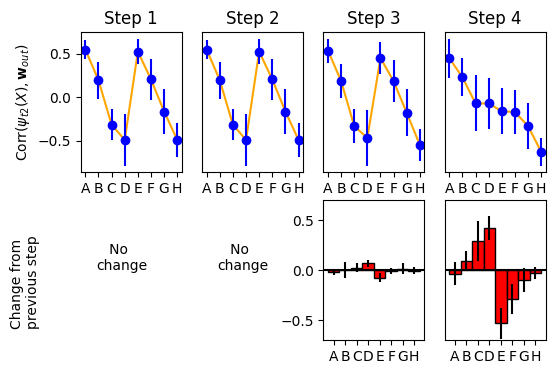

In [32]:
# Code uses 0 counting, but figure legends use 1-counting: "Step  3" is step2, "Step 4 " is step3.
plt.figure(figsize=(6,4))


nump=0




SHOWALLSELECTS = True

if SHOWALLSELECTS:
    myselects = selects
else:
    myselects = selectsadd




# print(">",cp.shape, corr.shape)
# myselects = np.isin(cp[:,18,0], [3,4]) & np.isin(cp[:,18,1], [3,4]) & ~corr[:,18]
# # myselects = np.isin(cp[:,18,0], [3,4]) & np.isin(cp[:,18,1], [3,4]) & corr[:,18]
# myselects = [x for x in range(myselects.shape[0]) if myselects[x]]  # Rest of the code expects a list of indices !



print(len(myselects))
ss = np.zeros(corrseachstep.shape[-1])
ss[myselects]  = 1
ss = ss>0  # BBoolean
pp(corrseachstep.shape)
# myselects = selectsadd
pp(corrseachstep[nump,:,:].shape)
pp(corrseachstep[nump,:,myselects].shape)  # Somehow this permutes dimensions....
pp(corrseachstep[nump,:,ss].shape)  # So does this
pp(corrseachstep[nump,:,myselects].T.shape)  # So need to permute back
pp(np.mean(corrseachstep[nump,:,myselects].T, axis=1).shape)


for nump in range(4):
    plt.subplot(2,4,1+nump)

    plt.xticks(np.arange(8), alphabet[:8])
    plt.plot(np.array(np.mean(corrseachstep[nump,:,myselects].T, axis=1)), 'orange')
    plt.errorbar(np.arange(8), np.mean(corrseachstep[nump,:,myselects].T, axis=1),yerr=np.std(corrseachstep[nump,:,myselects].T, axis=1),color='b', marker='o', linestyle='none')

    # plt.xticks(np.arange(8), alphabet[:8])
    # plt.plot(np.mean(corrseachstep[nump,:,myselects].T, axis=1))  # Again, the .T is just there to cancel weird dimension-permuting by numpy when using """smart""" indexing
    # plt.plot(np.mean(corrseachstep[nump,:,myselects].T, axis=1), 'o')
    # plt.xlabel("Single Cue (X)")
    plt.title('Step '+str(nump+1))
    if nump == 0:
        plt.ylabel("Corr($\psi_{t2}(X), \mathbf{w}_{out}$)")
    else:
        plt.yticks([])



for nump in range(4):
    plt.subplot(2,4,5+nump)
    if nump>1:
        corrdiffs =  corrseachstep[nump,:,myselects].T - corrseachstep[nump - 1,:,myselects].T
        # plt.title("Step 3")  # 1-counting in the paper
        plt.axhline(0, color='k')
        plt.bar(list(range(8)), np.mean(corrdiffs, axis=1), yerr=np.std(corrdiffs, axis=1) ,
            color='r',edgecolor='k', lw=1, width=1.0)
        # plt.bar(list(range(8)), np.median(corrdiffs, axis=1), yerr=np.vstack( ( np.quantile(corrdiffs, .75, axis=1) -np.median(corrdiffs, axis=1) ,
        #     np.median(corrdiffs, axis=1)  - np.quantile(corrdiffs, .25, axis=1)) )  ,
        #     color='r',edgecolor='k', lw=1, width=1.0)
        plt.ylim([-.7,.7])
        plt.xticks(range(8), alphabet[:8])
        if nump ==3:
            plt.yticks([])
    else:
        plt.axis('off')
        if nump==0:
            plt.text(-.7, .1, "Change from\nprevious step", rotation=90)
        plt.text(0.15,.5,'   No\nchange')

# plt.tight_layout()

plt.savefig('corrchanges'+str(BARREDPAIR[0])+str(BARREDPAIR[1])+('_add'+str(ADDBARREDPAIR[0])+str(ADDBARREDPAIR[1]) if not SHOWALLSELECTS else '')+'.png', dpi=300)


# Plot the acctual corr, in addition to the changes ni corr....

# # plt.plot(list(range(8)), [np.median(x) for x in step3corrdiffs])

0.0
7.91
(2000, 200, 200)
[[1.      0.07379]
 [0.07379 1.     ]]
ABSOLUTE CHANGES IN PLASTIC WEIGHTS BETWEEEN TIME STEPS, summed over whole batch
-0.07839457 0.039796952 -7.758944e-05
-0.039389513 0.042123027 -0.00022253327


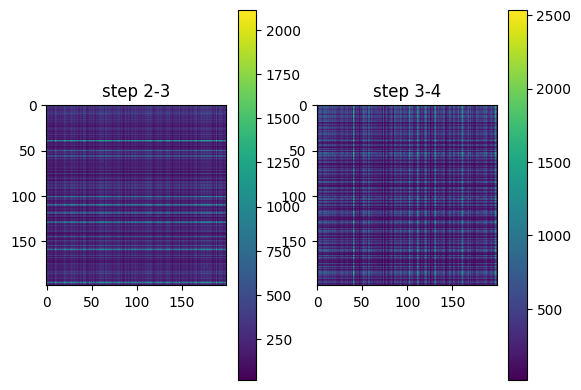

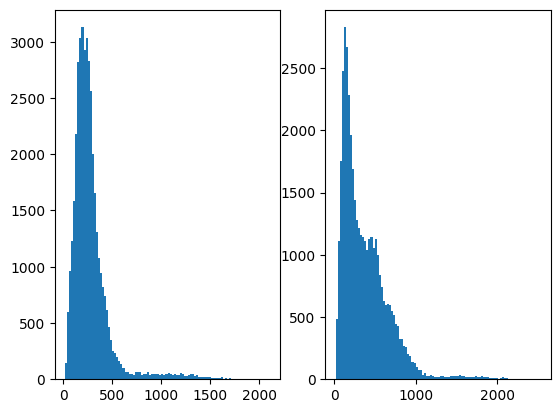

In [33]:
# The plastic weights that change most between steps 2-3 (coupling) are quite distinct from those that change most between steps 3-4 (representation changes) ?
# Actually correlation is ~0....
# But the matrices look really different! The former is mostly horizontal lines, the latter have much more vertical structure...
# However, the two groups (if they are groups) do not seem to have strongly different signs of alpha...


    # actualnumstep = NUMTRIALCHNGCORR * params['triallen'] + numstep
    # print("Actual step:", actualnumstep)
    # pwsavfull = allpwsavs_thisep[actualnumstep]

actualnumstep0 = NUMTRIALCHNGCORR * params['triallen']
pw1m0 = allpwsavs_thisep[actualnumstep0+1] - allpwsavs_thisep[actualnumstep0]
pw2m1 = allpwsavs_thisep[actualnumstep0+2] - allpwsavs_thisep[actualnumstep0+1]
pw3m2 = allpwsavs_thisep[actualnumstep0+3] - allpwsavs_thisep[actualnumstep0+2]

pw1m0 = pw1m0 ** 2
pw2m1 = pw2m1 ** 2
pw3m2 = pw3m2 ** 2
pw2m1_s = np.sum(pw2m1, axis=0)
pw3m2_s = np.sum(pw3m2, axis=0)
print(np.max(pw1m0)) # This one should be 0
print(np.max(pw2m1))
print(pw3m2.shape)  # 2000 200 200

print(np.corrcoef(pw2m1_s.flatten()>1000, pw3m2_s.flatten()>1000))
print("ABSOLUTE CHANGES IN PLASTIC WEIGHTS BETWEEEN TIME STEPS, summed over whole batch")
plt.figure()
plt.subplot(1,2,1)
plt.title("step 2-3")
plt.imshow(pw2m1_s)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("step 3-4")
plt.imshow(pw3m2_s)
plt.colorbar()
plt.figure()
plt.subplot(1,2,1)
plt.hist(pw2m1_s.flatten(),bins=100)
plt.subplot(1,2,2)
plt.hist(pw3m2_s.flatten(),bins=100)
aa = net.alpha.detach().cpu().numpy()
a1 = aa[pw2m1_s>1000]
a2 = aa[pw3m2_s>1000]
print(np.min(a1), np.max(a1), np.mean(a1))
print(np.min(a2), np.max(a2), np.mean(a2))


In [34]:
# This is an older analysis, requiring fixed cues for the entire batch


if False:

    # The pw change at step 3, *after* multiplication by alpha, correlates (negatively!) with the outer product of cue1pattern for  the showncues (and adjacents) with the output axis.

    # If not multiplying by alpha, this effect disappears (or is strrongly diminished and reveresed in sign??), confirming the importance of taking alpha into consideraton (and that the system itself does just tha)

    # This is all good and as predicted, but... the correlation is small! -.15/+.07 (tbf the change in correlation of 1-step output with wo, as per the previous cell, was also small: -.28/+.15)

    # The correlation is actually a bit lower when using outer product of cue1patterns with pca vector 0 ) the "decision axis") at step 1...

    # Requires Fixed Cues

    pwdiff = allpwsavs_thisep[NUMTRIALCHNGCORR * params['triallen'] + 3][NUMBECHNGCORR, :, :]  - allpwsavs_thisep[NUMTRIALCHNGCORR * params['triallen'] + 2][NUMBECHNGCORR, :, :]

    pwdiffalpha = pwdiff  * net.alpha.cpu().numpy()
    pwdiffnotalpha = pwdiff

    mats  =[]
    wo = net.h2o.weight.cpu().numpy()[0,:] # output weights
    for nc in range(8):
        mats.append(np.matmul(wo[:, None], cue1patterns[nc,:][None, :]))
        print("With alpha:", np.corrcoef(mats[nc].flatten(), pwdiffalpha.flatten())[0,1], ", without alpha:", np.corrcoef(mats[nc].flatten(), pwdiffnotalpha.flatten())[0,1])

    for nc in range(8):
        print("Projection of pwdiff over outer prod of  cue1 and wo (flattened, with alpha):", np.sum(mats[nc].flatten() * pwdiffalpha.flatten()) /  np.linalg.norm(mats[nc].flatten()))

    #The correlation is stronger when you add together the various outer products of the shown and adjacent cues with wo (with correct sign and multiplier), though still low (.2/.3)
    print(np.corrcoef((-.5  * mats[2] - mats[3] + mats[4] + .5 * mats[5]).flatten(), pwdiffalpha.flatten())[0,1])

In [35]:
# Same using PC 0 (note that sign is irrelevant  there)
if False:
    for nc in range(8):
        mat = np.matmul(pca.components_[0,:][:, None], cue1patterns[nc,:][None, :])
        print("With alpha:", np.corrcoef(mat.flatten(), pwdiffalpha.flatten())[0,1], ", without alpha:", np.corrcoef(mat.flatten(), pwdiffnotalpha.flatten())[0,1])

In [36]:
# Alternatively: we directly find the input vector (for each cue) and the output vector (common to all cues)
# such that their outer product * alpha, when multiplied by the same cue's FF representation, best matches the output weights

#This is only for one single batch element !!! This was an early analysis. The one actually used for the paper performs the search for all batch elements. See below.

#Need to add net.w, with a small multiplier to match realistic relative sizes!

# Works ! BUT! The optimization  probblem seems to have two solutions.

# Outcome 1 (most frequent): the v1s are strongly represented at step 1, according to whetherr or not the corrresponding cues exhibit large change
# above,and have no  corr with step-0 (FF) cue representations, and v2 is strongly represented at step 2 and no corr with output weights.

# Outcome 2 (not changing anything else, just rre-runnning this vvery cell and the next  and leavinig everything else
# unchanged): the v1s have ~0 representationiat step 1, but are strongly correlated with the step-0 (FF) cue representtions (r>.7), and
# the v2 is moderately represented at step 1 and has corr .9 with output weights...


# This one uses cue1patternsallbatch, which does not require FixedCues.
# BUT!...
# It only uses the cue1 patterns of one element in batch!

if False:
    MYNUM = selects[1] # NUMBECHNGCORR

    if True:
        wo = net.h2o.weight.cpu().numpy()
        wo = wo[1,:] - wo[0,:] # output weights

        HS = params['hs']
        torch.set_grad_enabled(True)
        alph = torch.zeros(HS, HS)
        alph[:,:] = net.alpha[:,:]
        ww = torch.zeros(HS, HS)
        ww[:,:] = net.w[:,:]

        # cue1patterns has shape 8,200
        # cue1patternsallbatch[0] has shape 2000,200
        # c1ps = torch.from_numpy(cue1patterns)
        c1ps = np.vstack([x[MYNUM,:] for x in cue1patternsallbatch])
        c1ps = torch.from_numpy(c1ps)
        wwo = torch.from_numpy(wo)

        v1s = []
        for nc in range(8):
            v1s.append( torch.rand(HS, requires_grad=True) )
            v1s[nc].data = .01 * (v1s[nc].data - .5)

        v2 = torch.rand(HS, requires_grad=True)
        v2.data = .01 * (v2.data - .5)

        optimexp = torch.optim.Adam((v1s + [v2]), lr=3e-4,  weight_decay=1e-3)
        # optimexp = torch.optim.Adam((v1s + [v2]), lr=3e-4,  weight_decay=1e-2)
        # optimexp = torch.optim.Adam((v1s + [v2]), lr=1e-3,  weight_decay=1e-2)
        for numstep in  range(3000):
            optimexp.zero_grad()
            loss = 0
            for nc in range(8):
                # tgtmat = torch.flatten(torch.from_numpy(mats[nc])).detach()
                outer = torch.matmul(v2[:, None], v1s[nc][None,:])
                # outera  =  .03*ww.detach()+outer * alph.detach()
                outera  =  .3*ww.detach()+outer * alph.detach()
                prod = torch.matmul(outera, c1ps[nc,:].detach())
                cc = torch.corrcoef(torch.vstack( (prod, wwo) ))
                # print(cc)
                loss += -cc[0,1]  / 8
                # if numstep  % 10 == 0:
                #     print(float(loss))
            loss.backward()
            if numstep % 100 == 0:
                print("loss:", float(loss))
            optimexp.step()

        torch.set_grad_enabled(False)
        print("THIS IS ONLY FOR BATCH ELEMENT", MYNUM)


In [37]:

# Probing: are the vectors found  above actually generated by the system in its activations? (Again, this one is for a single batch element!) (Be sure to use the same batch element as above)


# THERE ARE TWO POSSIBLE PATTERNS, for the exact same data, based on the outcome of the grad desc process in the cell above:
# 1- v1s match the FF (step-0) representatiions of the cues and V2 matches the H at step 1 (2nd step), and also the output wights
# 2- v1s of cues shown in that trial (and their adjacent cues in each direction) match the H at step 1, and v2 matches H at step 2 (with arbitrary sign).
#
# Note: outcome 2  seems to  result in better (more  negative) loss in the prvious cell's optimization. (~-.84)
#
#BUT Now with better optimization outcome 1 never  happens

# Remarkable match between each cue's correlation with h(t) (as seen here), and whether the corresponding cue had a change in representation alignment above, for any given batch element !
# E.g. if one cue failed to change its alignment, its corresponding v1 will not be represented in h (will have no correlation with h(time step 1), as computed here)...

# MYNUM IS DEFINED IN PREVIOUS CELL,  DON'T CHANGE

if False:


    print("Cue pairs for batch element", MYNUM, ":")
    print(np.hstack((cp[MYNUM,:,:], np.arange(cp.shape[1])[:, None])).T)
    print("Responses of batch element", MYNUM, ":")
    print(resps[MYNUM,  :])


    print("Correlations between the  found v1's (estimates of 'optimal' step-1 representations to produce learning)")
    print(allrates.shape, v1s[0].shape, np.vstack(v1s).shape, np.corrcoef(np.vstack(v1s)).shape)
    np.set_printoptions(suppress=True)
    print(np.corrcoef(np.vstack(v1s)))

    print("Correlation between the actual cues themselves:")
    cc = np.array(cuedata[MYNUM])
    print(np.corrcoef(cc))

    alph =  net.alpha.detach().cpu().numpy()

    print("Correlation  between found v1s and the FF (step-0) representation of the corresponding cue:")
    for nc in range(8):
        # mats.append(np.matmul(wo[:, None], cue1patterns[nc,:][None, :]))
        # print( np.corrcoef(mats[nc].flatten(),  (np.matmul( v2.detach()[:, None], v1s[nc].detach()[None,:] ) * alph).flatten())[0,1] )
        # print( np.corrcoef(v1s[nc].detach(), cue1patterns[nc,:] )[0,1] )
        print( np.corrcoef(v1s[nc].detach(), cue1patternsallbatch[nc][NUMBECHNGCORR,:] )[0,1] )

    print("==")
    ZS = (NUMTRIALCHNGCORR) *params['triallen'] + 1

    print("Correlation  between found v1s and the H vector at timestep",ZS," for BE", MYNUM,":")
    for nc in range(8):
        print( np.corrcoef(v1s[nc].detach(), allrates[MYNUM,:, ZS] )[0,1] )

    print("Correlation  between found v1s and the H vector at timestep 0 for BE", MYNUM,"(should be ~0 because it's trial step 0):")
    for nc in range(8):
        print( np.corrcoef(v1s[nc].detach(), allrates[MYNUM,:, 0] )[0,1] )
    print("Correlation  between found v1s and the H vector at timestep 1 for BE", MYNUM,"(should be high+ for 1st cue of trial 0  and high- for 2nd cue of trial 0 -or vice versa):")
    for nc in range(8):
        print( np.corrcoef(v1s[nc].detach(), allrates[MYNUM,:, 1] )[0,1] )
    print("Correlation  between found v1s and the H vector at timestep 5 for BE", MYNUM,"(should be high+ for 1st cue of trial 1  and high- for 2nd cue of trial 1 -or vice versa):")
    for nc in range(8):
        print( np.corrcoef(v1s[nc].detach(), allrates[MYNUM,:, 5] )[0,1] )
    print("==")
    print("Correlation  between found v2 and the H vector at timesteps",ZS-1,"to", ZS+2, "(incl) (BE",MYNUM,"):")
    print( np.corrcoef(v2.detach(), allrates[MYNUM,:, ZS-1] )[0,1] )
    print( np.corrcoef(v2.detach(), allrates[MYNUM,:, ZS] )[0,1] )
    print( np.corrcoef(v2.detach(), allrates[MYNUM,:, ZS+1] )[0,1] )
    print( np.corrcoef(v2.detach(), allrates[MYNUM,:, ZS+2] )[0,1] )
    print("==")
    print("Correlation btweeen found v2 and output weights:")
    print( np.corrcoef(v2.detach(), wo )[0,1] )




In [38]:
# This is the one actually used in the paper.

# We optimize to find a set of v1s for each element in batch, and  single commmon  v2 for the whole batch.

# More precisely: we directly find the input vector v1s (for each cue in each batch element) and the output vector v2  (common to all cues)
# such that their outer product * alpha + w (the +w is important!), when multiplied by the same cue's FF representation, best matches the output weights vector wo.

# Need to add net.w,  possibly with a small multiplier to help match the small sizes of the v1s and v2

# Works ! BUT! In some circumstances, the optimization  problem seems to have two solutions.

# Outcome 1 (most frequent): the v1s are strongly represented at step 1 (i.e. 2nd step), according to whetherr or not the corrresponding cues exhibit large change
# above,and have no  corr with step-0 (FF) cue representations, and v2 is strongly represented at step 2 and no corr with output weights.

# Outcome 2 (not changing anything else, just re-runnning this very cell and the next  and leaving everything else
# unchanged): the v1s have ~0 representationiat step 1, but are strongly correlated with the step-0 (FF) cue representtions (r>.7), and
# the v2 is moderately represented at step 1 and has corr .9 with output weights... Basically  ignores alpha and w

# FINDING: With better training (higher multiplier on w, mmore time,  higher lr, etc.), the proportion of outome-2 becomes very low. But you need to watch out!

# Also, if the final loss is ~-8000 or lower, you're generally in outcome 1.


if True:
    MYBS =  params['bs']
    HS = params['hs']

    torch.set_grad_enabled(True)
    alph = torch.zeros(HS, HS).to(device)
    alph[:,:] = net.alpha[:,:]
    ww = torch.zeros(HS, HS).to(device)
    ww[:,:] = net.w[:,:]

    # cue1patterns has shape 8,200
    # cue1patternsallbatch[0] has shape 2000,200
    # c1ps = torch.from_numpy(cue1patterns)
    # c1ps = np.vstack([x[NUMBECHNGCORR,:] for x in cue1patternsallbatch])
    c1ps = [torch.from_numpy(x).to(device) for x in cue1patternsallbatch]

    wo = net.h2o.weight.cpu().detach().numpy()
    wo =wo[1,:]  - wo[0,:] # output weights
    wwo = torch.from_numpy(wo).to(device)  # wwo is just a vector

    v1s = []
    for nc in range(8):
        v1s.append( torch.rand(MYBS, 1, HS, requires_grad=True, device=device) )
        v1s[nc].data = .01 * (v1s[nc].data - .5)

    # v2 = torch.rand(MYBS, HS, 1, requires_grad=True, device=device)
    v2 = torch.rand(HS, 1, requires_grad=True, device=device)  # No bbatch dimension !  1 common  v2 for the whole batch!So no worries about signs.
    v2.data = .01 * (v2.data - .5)



    # optimexp = torch.optim.Adam((v1s + [v2]), lr=3e-4,  weight_decay=1e-2)
    optimexp = torch.optim.Adam((v1s + [v2]), lr=1e-3,  weight_decay=1e-2)
    # optimexp = torch.optim.Adam((v1s + [v2]), lr=1e-3,  weight_decay=1e-3)
    # optimexp = torch.optim.Adam((v1s + [v2]), lr=1e-3,  weight_decay=1e-3)
    for numstep in  range(1000):
        optimexp.zero_grad()
        loss = 0
        for nc in range(8):
            # tgtmat = torch.flatten(torch.from_numpy(mats[nc])).detach()
            # outer = torch.matmul(v2[:, None], v1s[nc][None,:])
            outer = torch.matmul(v2[None,  :, :], v1s[nc])  # Outer has shape 2000, 200, 200 - as expected (batched outer product)
            outera  =  1.0 * ww.detach()[None,:,:] +outer * alph.detach()[None,:,:]  # outera:   2000, 200, 200
            prod = torch.matmul(outera, c1ps[nc].detach()[:, :, None])  #  prrod has shape 2000, 200, 1

            cc = torch.nn.functional.cosine_similarity(prod, wwo[None,:,None].detach())  # cc should have shape  2000,1
            # cc = torch.corrcoef(torch.hstack( (prod, wwo) ))  # hstack, not vstack
            # loss += -cc[0,1]  / 8
            loss += -torch.sum(cc)
            # if numstep  % 10 == 0:
            #     print(float(loss))
        loss.backward()
        if numstep % 30 == 0:
            print("loss:", float(loss))
        optimexp.step()

    torch.set_grad_enabled(False)


loss: -374.7705078125
loss: -382.38385009765625
loss: -418.757080078125
loss: -494.4047546386719
loss: -612.4525756835938
loss: -773.2424926757812
loss: -976.0242309570312
loss: -1219.3623046875
loss: -1501.142333984375
loss: -1818.48095703125
loss: -2167.63427734375
loss: -2543.9697265625
loss: -2942.02978515625
loss: -3355.71240234375
loss: -3778.5693359375
loss: -4204.16650390625
loss: -4626.46337890625
loss: -5040.1455078125
loss: -5440.85791015625
loss: -5825.314453125
loss: -6191.2783203125
loss: -6537.4619140625
loss: -6863.36474609375
loss: -7169.1015625
loss: -7455.22998046875
loss: -7722.6123046875
loss: -7972.2900390625
loss: -8205.4013671875
loss: -8423.115234375
loss: -8626.5888671875
loss: -8816.93359375
loss: -8995.205078125
loss: -9162.3876953125
loss: -9319.3916015625


In [39]:
v2N = v2.cpu().detach().numpy()
pp(v2N.shape)  # 200  1
pp(resps.shape)  # 2000 30
pp(corr.shape) # 2000, 30

# Same sign in curve above. Corr withresp here is strong-negative [[ 1.      -0.97788]. Again. Opposite sign:  positive correlation.

ZS = (NUMTRIALCHNGCORR) *params['triallen'] + 1  # Step 1 of trial 18


numstep  =  ZS+1
tmp1 = torch.from_numpy(v2N[None, :,0])  # 1, 200.
tmp2 = torch.from_numpy(allrates[:,:, numstep])
sims = torch.nn.functional.cosine_similarity(tmp1, tmp2).numpy()  # 2000. We use cosine_similarity because it can be  done in a batch
print(np.vstack((sims[:10], resps[:10, NUMTRIALCHNGCORR])))
print(np.corrcoef(sims, resps[:, NUMTRIALCHNGCORR]))
print(np.corrcoef(sims, corr[:, NUMTRIALCHNGCORR]))

pp("--")

# At early trial, v2N is still well represented in r(t+2), and correlation with actual response is also high (if anything higher)

EARLYTRIAL = 5

numstep = EARLYTRIAL *  params['triallen'] + 2
tmp1 = torch.from_numpy(v2N[None, :,0])  # 1, 200.
tmp2 = torch.from_numpy(allrates[:,:, numstep])
sims = torch.nn.functional.cosine_similarity(tmp1, tmp2).numpy()  # 2000. We use cosine_similarity because it can be  done in a batch
print(np.vstack((sims[:10], resps[:10, EARLYTRIAL])))
print(np.corrcoef(sims, resps[:, EARLYTRIAL]))
print(np.corrcoef(sims, corr[:, EARLYTRIAL]))

poscorr  = np.corrcoef(sims, resps[:, EARLYTRIAL])[0,1] > 0
pp('--')

if poscorr:
    print("Corr b/w found v2 and response  is positive, nothing to do.")
else:
    print("Corr b/w found v2 and response  is negative, flipping v1 and  v2")
    v2 = -v2
    v1s = [-x for x in v1s]

(200, 1)
(2000, 30)
(2000, 30)
[[-0.40419  0.38931  0.57349  0.40903  0.40157  0.54461 -0.40058 -0.29625 -0.47229 -0.50415]
 [ 1.      -1.      -1.      -1.      -1.      -1.       1.       1.       1.       1.     ]]
[[ 1.      -0.98411]
 [-0.98411  1.     ]]
[[1.     0.0156]
 [0.0156 1.    ]]
--
[[-0.43769 -0.59316 -0.59855 -0.62674  0.5084  -0.54733 -0.578    0.56708  0.542   -0.6289 ]
 [ 1.       1.       1.       1.      -1.       1.       1.      -1.      -1.       1.     ]]
[[ 1.      -0.99336]
 [-0.99336  1.     ]]
[[ 1.      -0.05928]
 [-0.05928  1.     ]]
--
Corr b/w found v2 and response  is negative, flipping v1 and  v2


In [40]:
print(outer.shape)
print(outera.shape)
print(prod.shape)
print(c1ps[0].shape)
print(cc.shape)
print(v1s[0].shape, v2.shape)
print(cue1patternsallbatch[0].shape)


torch.Size([2000, 200, 200])
torch.Size([2000, 200, 200])
torch.Size([2000, 200, 1])
torch.Size([2000, 200])
torch.Size([2000, 1])
torch.Size([2000, 1, 200]) torch.Size([200, 1])
(2000, 200)


In [41]:
# First, we test our found v1s and v2 for a single batch  element, looking at which v1s are represented (if any) at various
# points in the episode (we use the  v1s for this batch element, of course)

alph =  net.alpha.detach().cpu().numpy()
v1sN = [x.cpu().detach().numpy() for x in v1s]
v2N = v2.cpu().detach().numpy()

MYNUM = selects[1]
# MYNUM = NUMBECHNGCORR

wo = net.h2o.weight.cpu().detach().numpy()
wo =wo[1,:]  - wo[0,:] # output weights

print("Correlation  between found v1s and the FF (step-0) representation of the corresponding cue:")
for nc in range(8):
    print( np.corrcoef(v1sN[nc][MYNUM,0,:], cue1patternsallbatch[nc][MYNUM,:] )[0,1] )
        #   torch.nn.functional.cosine_similarity(  torch.from_numpy(v1sN[nc][MYNUM,0,:][None,:]), torch.from_numpy(cue1patternsallbatch[nc][MYNUM,:][None,:])))


print("==")
ZS = (NUMTRIALCHNGCORR) *params['triallen'] + 1

print("Correlation  between found v1s and the H vector at timestep",ZS," (BE",MYNUM,"):")
for nc in range(8):
    print( np.corrcoef(v1sN[nc][MYNUM,0,:], allrates[MYNUM,:, ZS] )[0,1] )
print("==")
print("Correlation  between found v2 and the H vector at timesteps",ZS-1,"to", ZS+2, "(incl):")
print( np.corrcoef(v2N[:,0], allrates[MYNUM,:, ZS-1] )[0,1] )
print( np.corrcoef(v2N[:,0], allrates[MYNUM,:, ZS] )[0,1] )
print( np.corrcoef(v2N[:,0], allrates[MYNUM,:, ZS+1] )[0,1] )
print( np.corrcoef(v2N[:,0], allrates[MYNUM,:, ZS+2] )[0,1] )
print("==")
print("Correlation btweeen found v2 and output weights:")
print( np.corrcoef(v2N[:,0], wo )[0,1] )



Correlation  between found v1s and the FF (step-0) representation of the corresponding cue:
-0.045646921803489
-0.00804298809575045
-0.0993425721710001
-0.061131972913340354
0.012190701088496281
0.011786834125689752
0.07176960958571746
0.12975464391928548
==
Correlation  between found v1s and the H vector at timestep 73  (BE 23 ):
0.09095625354521793
0.17503049911318813
0.2439171356592476
0.2739290761217605
-0.29476974070232087
-0.18848826369459395
-0.1563675741978925
-0.1377865284364459
==
Correlation  between found v2 and the H vector at timesteps 72 to 75 (incl):
0.095466700039996
0.02361188090609269
-0.6559835220320807
0.035573489781988675
==
Correlation btweeen found v2 and output weights:
-0.013816492152703842


(2000, 1, 200) (200, 1) (200,)
(2000, 30, 2) .
> (8, 2000, 200)
selected in ss1: 128 | selected in ss2 160
Step 72 :
Adapted cue 0 : -0.004755984958885974
Adapted cue 1 : -0.006345563016003904
Adapted cue 2 : -0.007236478316513342
Adapted cue 3 : -0.0001822919594858893
Adapted cue 4 : -0.0010416379564496697
Adapted cue 5 : -0.0020029365798464797
Adapted cue 6 : -0.0018652197387519394
Adapted cue 7 : 0.0005937337218097274
Step 73 :
Adapted cue 0 : 0.0040431290275284365
Adapted cue 1 : 0.04627020169793657
Adapted cue 2 : 0.1190674948281494
Adapted cue 3 : 0.16729391044749783
Adapted cue 4 : -0.182357796334516
Adapted cue 5 : -0.12534477654752135
Adapted cue 6 : -0.047237632697985484
Adapted cue 7 : -0.02061252362296733
Step 74 :
Adapted cue 0 : -0.0072992599619519346
Adapted cue 1 : -0.012552194248805052
Adapted cue 2 : -0.011881779631918813
Adapted cue 3 : -0.013511326869652004
Adapted cue 4 : -0.013447869544542242
Adapted cue 5 : -0.014886119059101269
Adapted cue 6 : -0.009294446952952

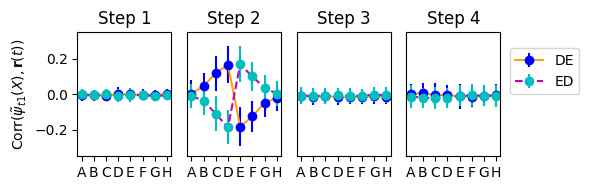

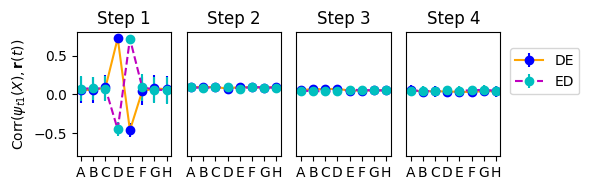

In [42]:
# Average representation of the v1s for  each cue at time step 1 of trial 18, only for the selected batch elements (i.e. those who hadeither 3-4 or
# 4-3 on thistrial, and it was the first time they saw either)

# Importantly, you need to adapt the sign of the v1s depending on whether it's 3-4 or 4-3. The first cue represents iits v1s with positive sign, the seond cue represents them with negative signs

#So we show the curves separately  for 3-4 and 4-3

#print( np.corrcoef(v2N[MYNUM,:,0], allrates[MYNUM,:, ZS+1] )[0,1] )
# v2N: 2000, 200, 1
# allrates[:,:,ZS+!]:  2000,  200
v1sN = [x.cpu().detach().numpy() for x in v1s]
v2N = v2.cpu().detach().numpy()

print(v1sN[0].shape, v2N.shape, wo.shape)
print(cp.shape,".")

cue1patternsallbatchN = np.array(cue1patternsallbatch)
pp(">",  cue1patternsallbatchN.shape)

ZS = (NUMTRIALCHNGCORR) *params['triallen'] + 1  #  Step 1 of trial 18, again

allsims=None


# We extract the runs where the cues of trial NUMTRIALCHNGCORR are D and E, shown in the right order
# These do  NOT need to be from 'selects' !
# ss1 = np.zeros(cp.shape[0]); ss1[selects] = 1; ss1[cp[:,18,0] <  cp[:, 18,  1]] = 0; ss1 = ss1>0;
# ss2 = np.zeros(cp.shape[0]); ss2[selects] = 1; ss2[cp[:,18,0] >  cp[:, 18,  1]] = 0; ss2 = ss2>0;
ss1 = (cp[:,NUMTRIALCHNGCORR,0]  ==  3) & (cp[:,NUMTRIALCHNGCORR,1]  ==  4)
ss2 = (cp[:,NUMTRIALCHNGCORR,0]  ==  4) & (cp[:,NUMTRIALCHNGCORR,1]  ==  3)


pp("selected in ss1:", np.sum(ss1), "| selected in ss2", np.sum(ss2))


allsims_adap=[]
allsims_orig=[]
for numstep in range(ZS-1, ZS+3):
    print("Step", numstep, ":")
    allsims_adap_thisstep = []
    allsims_orig_thisstep = []
    for nc in range(8):
        tmp1  = torch.from_numpy(v1sN[nc][:,0,:])  # 2000, 200.  The 0 is a dummy dimension
        tmp1b = torch.from_numpy(cue1patternsallbatchN[nc,:,:])  # 2000, 200.
        tmp2 = torch.from_numpy(allrates[:,:, numstep])
        allsims_adap_thisstep.append( torch.nn.functional.cosine_similarity(tmp1, tmp2).numpy() ) # 2000. We use cosine_similarity because it can be  done in a batch
        allsims_orig_thisstep.append( torch.nn.functional.cosine_similarity(tmp1b, tmp2).numpy() ) # 2000. We use cosine_similarity because it can be  done in a batch
        print("Adapted cue", nc, ":", np.mean(allsims_adap_thisstep[nc][ss1]))

    allsims_adap.append(allsims_adap_thisstep)
    allsims_orig.append(allsims_orig_thisstep)

allsims_adap = np.array(allsims_adap)  # 4  steps x 8 cues x 2000 batch elements
allsims_orig = np.array(allsims_orig)  # 4  steps x 8 cues x 2000 batch elements
pp( allsims_adap.shape )


for numfig in range(2):

    quantitytoplot = [allsims_adap, allsims_orig][numfig]

    plt.figure(figsize=(6,2))

    for nump in range(4):
        plt.subplot(1,4,1+nump)
        # plt.axhline(0, color='gray')

        plt.xticks(np.arange(8), alphabet[:8])
        plt.ylim([-.35, .35] if numfig == 0 else [-.8, .8])
        plt.errorbar(np.arange(8), np.mean(quantitytoplot[nump,:,ss1].T, axis=1),yerr=np.std(quantitytoplot[nump,:,ss1].T, axis=1),
                    color='orange', ecolor='b', markerfacecolor='b', markeredgecolor='b', marker='o', label='DE')
        plt.errorbar(np.arange(8), np.mean(quantitytoplot[nump,:,ss2].T, axis=1),yerr=np.std(quantitytoplot[nump,:,ss2].T, axis=1),
                    color='m', linestyle='--', ecolor='c', markerfacecolor='c', markeredgecolor='c', marker='o',  label='ED')


        plt.title('Step '+str(nump+1))
        if nump == 3:
            plt.legend(loc=(1.1, .5))
        if nump == 0:
            plt.ylabel(r"Corr($\tilde{\psi}_{t1}(X), \mathbf{r}(t)$)" if numfig == 0 else  r"Corr($\psi_{t1}(X), \mathbf{r}(t)$)")
        else:
            plt.yticks([])

    plt.tight_layout()
    plt.savefig(("adapted" if numfig == 0 else "original")+"FFcuereps_t18_DEonly.png", dpi=300)



(2000,) (200, 1)
[ 0.42546 -0.38721 -0.57538 -0.41174 -0.39809 -0.54792  0.4064   0.29995  0.48009  0.51322]
[ 1 -1 -1 -1 -1 -1  1  1  1  1]
Correlation between response and representation of V2 at step 2 (3rd step) of trial 18, across batch:
0.9841713458084571
[-0.004372859211080787, -0.09928743745859518, 0.45840627831242964, -0.11510305900677407]
[-0.002240649733123203, -0.10544320569545505, -0.5319972562822118, -0.02395648042439256]


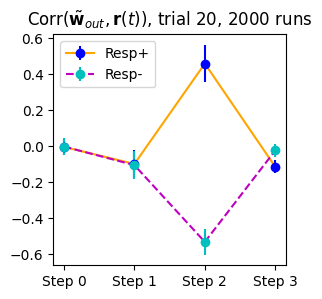

In [43]:
# V2, the optimization-found adapted 'output' vector for producing adequate learning, is represented at time step 3, with
# sign almost (but not quite) identical to the network's response for this trial

z = np.corrcoef(allrates[:,:, ZS+1], v2N[:,0] )[-1,:-1]
print(z.shape, v2N.shape)   # 2000  / 200,1
print(z[:10])
print(resps[:10,  18])
print("Correlation between response and representation of V2 at step 2 (3rd step) of trial 18, across batch:")
print(np.corrcoef(z, resps[:,18])[0,1])

# ss1 = (cp[:,18,0]  ==  3) & (cp[:,18,1]  ==  4)
# ss1 = cp[:, 18, 0] >  cp[:, 18, 1]
# ss2 = cp[:, 18, 0] <  cp[:, 18, 1]
ss1 = resps[:, NUMTRIALCHNGCORR] >0
ss2 = resps[:, NUMTRIALCHNGCORR] < 1


ZS = (NUMTRIALCHNGCORR) *params['triallen'] + 1  #  Step 1 of trial 18, again

meancorrs1 = []
meancorrs2 = []
stdcorrs1 = []
stdcorrs2 = []
for numstep in range(4):
    meancorrs1.append( np.mean(np.corrcoef(allrates[ss1,:, ZS-1+numstep], v2N[:,0] )[-1,:-1] ) )
    stdcorrs1.append( np.std(np.corrcoef(allrates[ss1,:, ZS-1+numstep], v2N[:,0] )[-1,:-1] ) )
    meancorrs2.append( np.mean(np.corrcoef(allrates[ss2,:, ZS-1+numstep], v2N[:,0] )[-1,:-1] ) )
    stdcorrs2.append( np.std(np.corrcoef(allrates[ss2,:, ZS-1+numstep], v2N[:,0] )[-1,:-1] ) )
print(meancorrs1)
print(meancorrs2)

plt.figure(figsize=(3,3))
plt.errorbar(np.arange(4), meancorrs1, yerr=stdcorrs1,
                    color='orange', ecolor='b', markerfacecolor='b', markeredgecolor='b', marker='o', label='Resp+')
plt.errorbar(np.arange(4), meancorrs2, yerr=stdcorrs2,
                    color='m', linestyle='--', ecolor='c', markerfacecolor='c', markeredgecolor='c', marker='o', label='Resp-')
plt.xticks(range(4), ['Step '+str(x) for x in range(4)])
plt.title(r"Corr($\mathbf{\tilde{w}}_{out}, \mathbf{r}(t)$), trial 20, 2000 runs")
plt.legend()
plt.savefig('adaptedwo.png', dpi=300)

(2000, 1, 200) (200, 1) (200,)
(2000, 30, 2) .
> (8, 2000, 200)
selected in ss1: 146 | selected in ss2 127
Step 0 :
Step 1 :
Step 2 :
Step 3 :
(4, 8, 2000)


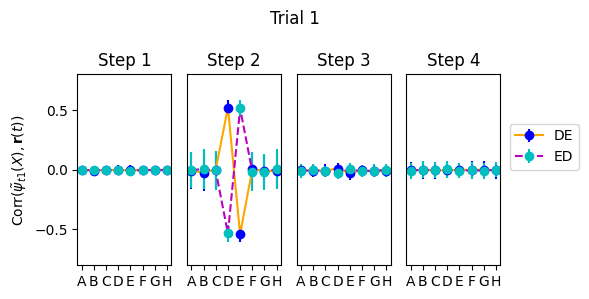

In [44]:
# Average representation of the v1s for  each cue at time step 1 of trial 0, only for the selected batch elements (i.e. those who hadeither 3-4 or
# 4-3 on thistrial, and it was the first time they saw either)

# This is for the first trial, before any learniong for this episode.

# Importantly, you need to switch the sign of the v1s depending on whetherr it's 3-4 or 4-3. The first cue represents iits v1s with positive sign, the seond cue represents them with negative signs

#Might  be  more appropriate toshow separately  for 3-4 and 4-3?

#print( np.corrcoef(v2N[MYNUM,:,0], allrates[MYNUM,:, ZS+1] )[0,1] )
# v2N: 2000, 200, 1
# allrates[:,:,ZS+!]:  2000,  200
v1sN = [x.cpu().detach().numpy() for x in v1s]
v2N = v2.cpu().detach().numpy()

print(v1sN[0].shape, v2N.shape, wo.shape)
print(cp.shape,".")

cue1patternsallbatchN = np.array(cue1patternsallbatch)
pp(">",  cue1patternsallbatchN.shape)



# Trial 1, cues 3/4 or 4/3
ss1 = (cp[:,0,0]  ==  3) & (cp[:,0,1]  ==  4)
ss2 = (cp[:,0,0]  ==  4) & (cp[:,0,1]  ==  3)


pp("selected in ss1:", np.sum(ss1), "| selected in ss2", np.sum(ss2))


allsimsT1=[]

for numstep in range(0, 4):
    print("Step", numstep, ":")
    allsimsT1_thisstep = []
    for nc in range(8):
        tmp1  = torch.from_numpy(v1sN[nc][:,0,:])  # 2000, 200.  The 0 is a dummy dimension
        tmp2 = torch.from_numpy(allrates[:,:, numstep])
        allsimsT1_thisstep.append( torch.nn.functional.cosine_similarity(tmp1, tmp2).numpy() ) # 2000. We use cosine_similarity because it can be  done in a batch
    allsimsT1.append(allsimsT1_thisstep)

allsimsT1 = np.array(allsimsT1)  # 4  steps x 8 cues x 2000 batch elements
pp( allsimsT1.shape )




plt.figure(figsize=(6,3))

for nump in range(4):
    plt.subplot(1,4,1+nump)
    # plt.axhline(0, color='gray')

    plt.xticks(np.arange(8), alphabet[:8])
    plt.ylim( [-.8, .8])
    plt.errorbar(np.arange(8), np.mean(allsimsT1[nump,:,ss1].T, axis=1),yerr=np.std(allsimsT1[nump,:,ss1].T, axis=1),
                color='orange', ecolor='b', markerfacecolor='b', markeredgecolor='b', marker='o', label='DE')
    plt.errorbar(np.arange(8), np.mean(allsimsT1[nump,:,ss2].T, axis=1),yerr=np.std(allsimsT1[nump,:,ss2].T, axis=1),
                color='m', linestyle='--', ecolor='c', markerfacecolor='c', markeredgecolor='c', marker='o',  label='ED')


    plt.title('Step '+str(nump+1))
    if nump == 3:
        plt.legend(loc=(1.1, .5))
    if nump == 0:
        plt.ylabel(r"Corr($\tilde{\psi}_{t1}(X), \mathbf{r}(t)$)" )
    else:
        plt.yticks([])
plt.suptitle("Trial 1")
plt.tight_layout()
plt.savefig("adaptedFFcuereps_t1_DEonly.png", dpi=300)



Step 73 :
(14, 8)


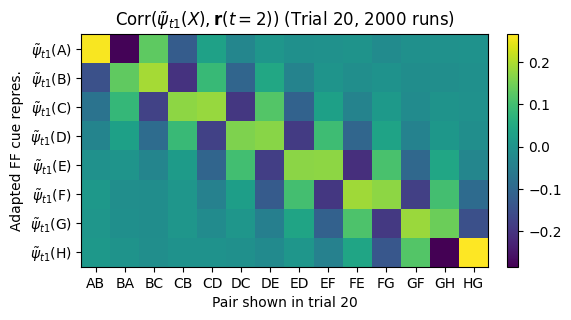

In [45]:

numstep = ZS
print("Step", numstep, ":")
meansims = []
zepairs = [[0,1], [1,0], [1,2], [2,1], [2,3], [3,2], [3,4], [4,3], [4,5], [5,4], [5,6], [6,5], [6,7], [7,6]  ]
for pair in zepairs:
    meansims_thispair = []
    ss = (cp[:,NUMTRIALCHNGCORR,0] == pair[0] ) & (cp[:,NUMTRIALCHNGCORR,1] == pair[1])
    for nc in range(8):
        tmp1  = torch.from_numpy(v1sN[nc][:,0,:])  # 2000, 200.  The 0 is a dummy dimension
        tmp2 = torch.from_numpy(allrates[:,:, numstep])
        sims = torch.nn.functional.cosine_similarity(tmp1, tmp2).numpy()  # 2000. We use cosine_similarity because it can be  done in a batch
        # allsims_thispair.append(sims)
        meansims_thispair.append(np.mean(sims[ss]))
    meansims.append(meansims_thispair)

meansims = np.array(meansims)
pp(meansims.shape)

plt.figure(figsize=(6,3))
plt.matshow(meansims.T, fignum=1)
plt.colorbar(fraction=0.026, pad=0.04)
plt.xticks(range(len(zepairs)), [alphabet[x[0]]+alphabet[x[1]] for x in zepairs])
plt.yticks(range(8), [r"$\tilde{\psi}_{t1}($"+str(alphabet[x])+r"$)$" for x in range(8)])
plt.tick_params(axis='x', labelbottom=True, labeltop=False, top=False)
plt.xlabel('Pair shown in trial 20')
plt.ylabel('Adapted FF cue repres.')
plt.title(r"Corr($\tilde{\psi}_{t1}(X), \mathbf{r}(t=2)$) (Trial 20, 2000 runs)")

plt.savefig("adaptedFFcuereps_t18_allpairs.png", dpi=300)



(4, 8, 2000)
(4, 8, 2000)
(2000, 30, 2)
[3, 4] [4, 5]
(2000, 120)
0.209
(2000, 30)
(2000, 30)
[-1  1]
ss1: 222
ss2: 66


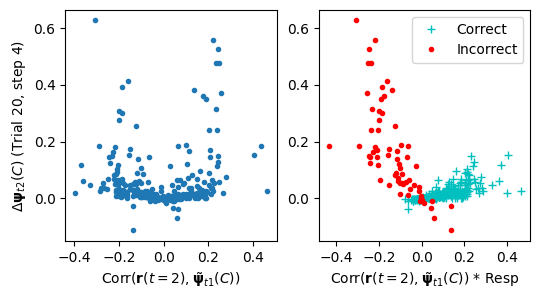

In [46]:

# NOTE: This picture looks better with HALFNOBARREDPAIRUNTILT18 = True (more data points)


# Correlation between how mmuch cue barredpair[0]-1 was represented in the firing rates of time step ZS (step 1 of
#trial 18), and how much change there wars in the step-1 representation of thhis  same cue at time step 3

# This graph is onlyuseful if selects is large



pp(allsims_adap.shape)  # 4 steps, 8  cues, 2000 batchsize
pp(corrseachstep.shape) # 4, 8, 2000: at each step, corrs of the step-1 (2nd step, after one pass through learned plastic weights) representation of each  cue with w_out (trial 18)
pp(cp.shape)  # 2000 , 30, 2
pp(BARREDPAIR, ADDBARREDPAIR)
pp(ds.shape)  # 2000, 120
dssign = np.sign(ds[:, params['triallen'] * 18 + 3])
print(np.mean(dssign<0))
pp(resps.shape)  # 2000, 30
pp(corr.shape)
pp(np.unique(resps))

ss = np.zeros(allsims_adap.shape[-1])
# ss[selects] = 1;  ss =ss>0   # Booleanize
# ss = (cp[:, 18, 0] == 3) &  (cp[:, 18, 1] == 4)
ss = np.isin(cp[:, 18, 0], BARREDPAIR) &  np.isin(cp[:, 18, 1], BARREDPAIR)


# # We look at  the one in the additional barred pair that is not part of the barred pair
# if max(ADDBARREDPAIR) > max(BARREDPAIR):
#     zecue = max(ADDBARREDPAIR)
# else:
#     zecue = min(ADDBARREDPAIR)

# Reminder:
# tmp1  = torch.from_numpy(v1sN[nc][:,0,:])  # 2000, 200.  The 0 is a dummy dimension
# tmp2 = torch.from_numpy(allrates[:,:, numstep])
# allsims_adap_thisstep.append( torch.nn.functional.cosine_similarity(tmp1, tmp2).numpy() ) # 2000. We use cosine_similarity because it can be  done in a batch


zecue = 2   # C
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot((allsims_adap[1, zecue,ss]) , corrseachstep[3, zecue,ss] - corrseachstep[2, zecue,ss] ,'.')
plt.xlabel(r"Corr($\mathbf{r}(t=2), \mathbf{\tilde{\psi}}_{t1}(C)$)")
plt.ylabel(r"$\Delta\mathbf{\psi}_{t2}(C)$ (Trial 20, step 4)")


ss1 = ss &  (corr[:,18] >0)# (np.abs(ds[:, params['triallen'] * 18 + 3])< .3)
ss2 = ss &  (corr[:,18] <1)# (np.abs(ds[:, params['triallen'] * 18 + 3])< .3)

pp("ss1:", np.sum(ss1))
pp("ss2:", np.sum(ss2))

plt.subplot(1,2,2)
# plt.plot((allsims_adap[1, zecue,ss1]) , (corrseachstep[3, zecue,ss1] - corrseachstep[2, zecue,ss1]) * resps[ss1, 18] ,'c+', label='Correct')
# plt.plot((allsims_adap[1, zecue,ss2]) , (corrseachstep[3, zecue,ss2] - corrseachstep[2, zecue,ss2]) * resps[ss2, 18] ,'r.',label='Incorrect')
plt.plot((allsims_adap[1, zecue,ss1])  * resps[ss1, 18], (corrseachstep[3, zecue,ss1] - corrseachstep[2, zecue,ss1]) ,'c+', label='Correct')
plt.plot((allsims_adap[1, zecue,ss2])  * resps[ss2, 18] , (corrseachstep[3, zecue,ss2] - corrseachstep[2, zecue,ss2]),'r.',label='Incorrect')
plt.xlabel(r"Corr($\mathbf{r}(t=2), \mathbf{\tilde{\psi}}_{t1}(C)$) * Resp")

plt.legend()


plt.savefig("psitildetodeltapsi.png", dpi=300)


In [47]:
# raise ValueError

In [48]:
print(len(ds))
print(np.shape(np.hstack(ds)))
print(len(rs))
print(np.shape(np.hstack(rs)))
print(rs[0].shape)
print(ds[0].shape)

2000
(240000,)
2000
(240000,)
(120,)
(120,)


In [49]:
print(cp[NUMBECHNGCORR,5,:])
print(cp[NUMBECHNGCORR,6,:])
print(cp[NUMBECHNGCORR,:7,:].T)

[1 0]
[6 7]
[[7 6 1 1 5 1 6]
 [6 7 2 0 6 0 7]]


(2000, 30, 2) (2000, 200, 120)
[15] - [1]
(1, 200)
[[ 1.      -0.28442]
 [-0.28442  1.     ]]
[[1.      0.16092]
 [0.16092 1.     ]]
[[1.      0.20717]
 [0.20717 1.     ]]
[[1.      0.19494]
 [0.19494 1.     ]]
[[ 1.      -0.08882]
 [-0.08882  1.     ]]
[[ 1.      -0.08737]
 [-0.08737  1.     ]]
[[1.     0.0661]
 [0.0661 1.    ]]


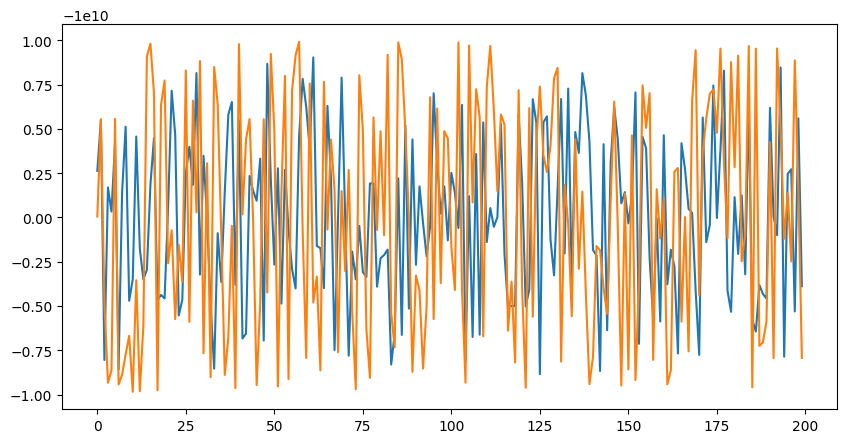

In [50]:
print(cp.shape, a.shape) # (5000, 35, 2) (5000, 200, 70) (70 = nbtrials * nbstepspertrial)
# am = allrates - np.mean(allrates, axis=0)[None,:,:]
am = allrates - 1e10
NUMOTHERTRIAL = 29
mask1 = np.argwhere((cp[:, 0, 0] == 2)  & (cp[:, 0, 1]==3) )
mask2 = np.argwhere  ((cp[:, 0, 0] == 3)  & (cp[:, 0, 1]==2) )
mask3 = np.argwhere  ((cp[:, 0, 0] == 2)  & (cp[:, 0, 1]==1) )
mask4 = np.argwhere  ((cp[:, 0, 0] == 6)  & (cp[:, 0, 1]==7) )
mask5 = np.argwhere  ((cp[:, 0, 0] == 0)  & (cp[:, 0, 1]==1) )
mask6 = np.argwhere  ((cp[:, 0, 0] == 1)  & (cp[:, 0, 1]==2) )
mask7 = np.argwhere  ((cp[:, NUMOTHERTRIAL, 0] == 2)  & (cp[:, NUMOTHERTRIAL, 1]==3) )
print(mask1[0], "-", mask2[0])
print(am[mask1[0], :, 0].shape)
print(np.corrcoef(am[mask1[0], :, 0], am[mask1[3], :, 0]))
print(np.corrcoef(am[mask1[0], :, 0], am[mask2[3], :, 0]))
print(np.corrcoef(am[mask1[0], :, 0], am[mask3[3], :, 0]))
print(np.corrcoef(am[mask1[0], :, 0], am[mask4[3], :, 0]))
print(np.corrcoef(am[mask1[0], :, 0], am[mask5[3], :, 0]))
print(np.corrcoef(am[mask1[0], :, 0], am[mask6[3], :, 0]))
print(np.corrcoef(am[mask1[0], :, 0], am[mask7[1], :, NUMOTHERTRIAL * 2]))
plt.figure(figsize=(10,5))
plt.plot(am[mask1[0], :, 0].T)
plt.plot(am[mask7[1], :, NUMOTHERTRIAL*2].T)


In [51]:
# print(nb, nt)
# print(p[:])
# print(cp[nb, nt,:])
# print(r[nb,nt])
# print(c[nb,nt])

In [52]:
# len(all_grad_norms)
# print(all_grad_norms[-2])
# gns  =  np.array([float(x) for x in all_grad_norms])
# print(np.mean(gns>1.9), np.mean(gns>1.49), np.mean(gns>.99))